In [1]:
import sys
import time
sys.path.append('/home/kevinteng/Desktop/BrainTumourSegmentation')
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os, random
import utils
from utils_vis import plot_comparison, plot_labels_color 
from utils import dice_coef, ss_metric, compute_metric
import nibabel as nib
from sklearn.model_selection import KFold
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

- Blue => Label 1 (Necrotic and Non-enhancing Tumor Core)
- Yellow => Label 2 (Peritumoral Edema)
- Green => Label 3/4 (GD-Enhancing Tumor)
---
* Core => Label 1 & 3
* Enhancing => Label 3
* Complete => Label 1,2, 3

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
max_epochs = 2
BATCH_SIZE = 24
lr = 0.00001
opt = tf.keras.optimizers.Adam(lr)
ver = 'DeepSupervisedAttentionUNet03' #save version 
dropout=0.3 #dropout rate
hn = 'he_normal' #kernel initializer 
tfrecords_read_dir = '/home/kevinteng/Desktop/ssd02/BraTS20_tfrecords03/'
stack_npy = "/home/kevinteng/Desktop/ssd02/BraTS2020_stack03/"

---

# Helper Functions

In [3]:
xent = tf.keras.losses.CategoricalCrossentropy()

def generalized_dice(y_true, y_pred, smooth = 1e-5):
    """
    Generalized Dice Score
    https://arxiv.org/pdf/1707.03237
    https://github.com/Mehrdad-Noori/Brain-Tumor-Segmentation/blob/master/loss.py
    """
    
    y_true    = tf.reshape(y_true,shape=(-1,4))
    y_pred    = tf.reshape(y_pred,shape=(-1,4))
    sum_p     = tf.reduce_sum(y_pred, -2)
    sum_r     = tf.reduce_sum(y_true, -2)
    sum_pr    = tf.reduce_sum(y_true * y_pred, -2)
    weights   = tf.math.pow(tf.math.square(sum_r) + smooth, -1)
    generalized_dice = (2 * tf.reduce_sum(weights * sum_pr)) / (tf.reduce_sum(weights * (sum_r + sum_p)))
    return generalized_dice

def generalized_dice_loss(y_true, y_pred):   
    return 1-generalized_dice(y_true, y_pred)
    
def custom_loss(y_true, y_pred):
    
    """
    The final loss function consists of the summation of two losses "GDL" and "CE"
    with a regularization term.
    """
    
    return generalized_dice_loss(y_true, y_pred) + 1.25 * xent(y_true, y_pred)

def data_aug(imgs, seed=8888):
    x = tf.image.random_flip_up_down(imgs,seed)
    x = tf.image.random_flip_left_right(x,seed)
    return x

----

# Model

In [4]:
from utils_model import conv_block, coordconv_block, up, pool, attention_block
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, Activation, Add, Multiply, GaussianNoise

def AttUnet_model(input_layer, attention_mode='grid'):
    gauss1 = GaussianNoise(0.01)(input_layer)
    #downsampling path
    conv1 = conv_block(gauss1, filters=64, kernel_initializer=hn)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128, kernel_initializer=hn)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, kernel_initializer=hn)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512, kernel_initializer=hn)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, kernel_initializer=hn)
    
    #upsampling path
    att01 = attention_block(conv4, conv5, 512)
    up1 = up(conv5,filters=512, merge=att01, kernel_initializer=hn)
    conv6 = conv_block(up1, filters=512, kernel_initializer=hn)
    
    if attention_mode=='grid':
        att02 = attention_block(conv3, conv6, 256)
    else:
        att02 = attention_block(conv3, conv4, 256)
    up2 = up(conv6, filters=256, merge=att02, kernel_initializer=hn)
    conv7 = conv_block(up2, filters=256, kernel_initializer=hn)
    #injection block 1
    seg01 = Conv2D(4,(1,1),padding='same')(conv7)
    up_seg01 = UpSampling2D()(seg01)
    
    if attention_mode=='grid':
        att03 = attention_block(conv2, conv7, 128)
    else:
        att03 = attention_block(conv2, conv3, 128)
    up3 = up(conv7, filters=128, merge=att03, kernel_initializer=hn)
    conv8 = conv_block(up3, filters=128, kernel_initializer=hn)
    #injection block 2
    seg02 = Conv2D(4,(1,1),padding='same')(conv8)
    add_21 = Add()([seg02, up_seg01])
    up_seg02 = UpSampling2D()(add_21)
    
    if attention_mode=='grid':
        att04 = attention_block(conv1, conv8, 64)
    else:
        att04 = attention_block(conv1, conv2, 64)
    up4 = up(conv8, filters=64, merge=att04, kernel_initializer=hn)
    conv9 = conv_block(up4, filters=64, kernel_initializer=hn)
    #injection block 3
    seg03 = Conv2D(4,(1,1),padding='same')(conv9)
    add_32 = Add()([seg03, up_seg02])
    
    output_layer = Conv2D(4, (1,1), activation = 'softmax')(add_32)
    
    return output_layer

In [5]:
#Build Model
input_layer = Input(shape=(240,240,4))
model = Model(input_layer, AttUnet_model(input_layer))

In [6]:
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = model(image, training=True)
        loss = custom_loss(label, model_output)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    
    return model_output, loss, gradients

@tf.function
def val_fn(image, label):
    model_output = model(image, training=False)
    loss = custom_loss(label, model_output)
    return model_output, loss

---

Fold: 1
Epochs  1



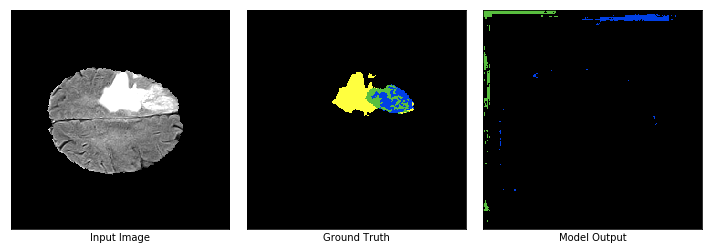

Steps: 1, Loss:1.8793829679489136
Accurary: 0.9367361068725586
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [8.81057260959848e-09, 1.808318231314318e-08, 4.105090295135097e-09]
Specificity: [0.9786062162439376, 0.9871158869025337, 0.9781016605071964]
Gradient min:-0.04208223149180412, max:0.05357782542705536



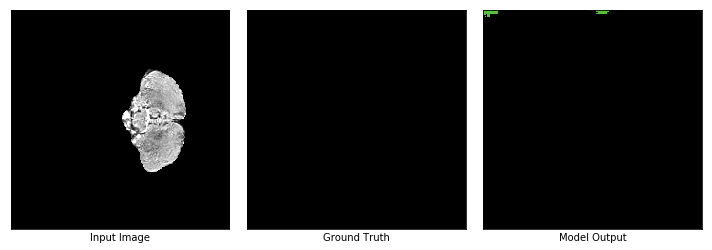

Steps: 2, Loss:1.4221441745758057
Accurary: 0.9975520968437195
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9975520833337583, 0.9975520833337583, 0.9975520833337583]
Gradient min:-0.028865860775113106, max:0.05171561986207962



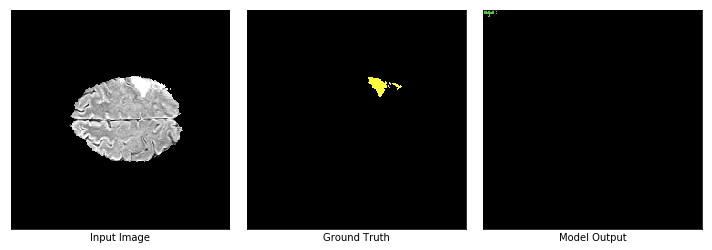

Steps: 3, Loss:1.3716768026351929
Accurary: 0.9940277934074402
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 3.4722221016589556e-08]
Specificity: [0.9990277777779466, 0.9990277777779466, 0.9990228922391431]
Gradient min:-0.014749554917216301, max:0.02877737767994404



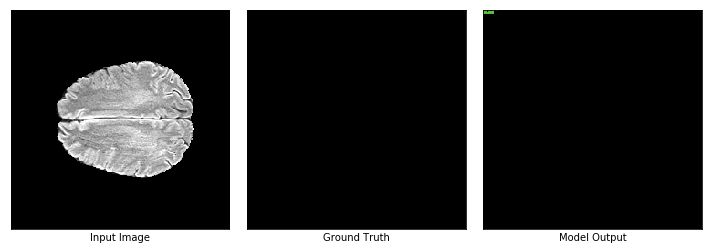

Steps: 4, Loss:1.3719524145126343
Accurary: 0.9992534518241882
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9992534722223518, 0.9992534722223518, 0.9992534722223518]
Gradient min:-0.011358547955751419, max:0.019629914313554764



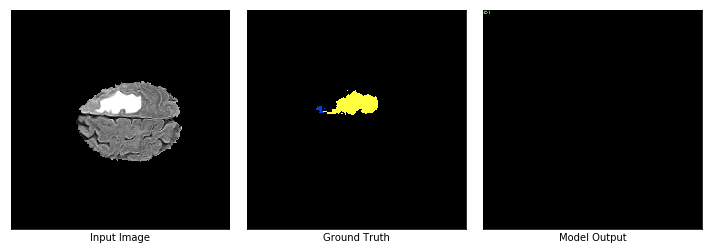

Steps: 5, Loss:1.3730331659317017
Accurary: 0.9831944704055786
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [2.43902379536005e-07, 1.0, 1.0548523095479715e-08]
Specificity: [0.9996525304470799, 0.999652777777838, 0.9996469674504612]
Gradient min:-0.010493280366063118, max:0.012978696264326572



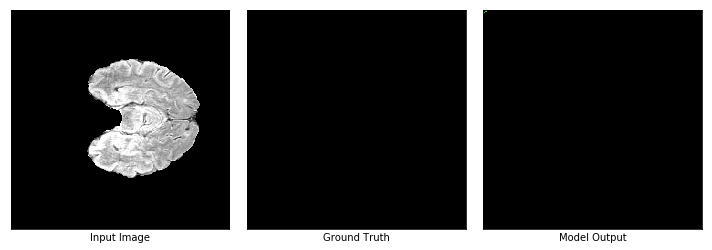

Steps: 6, Loss:1.1759675741195679
Accurary: 0.9998611211776733
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9998611111111352, 0.9998611111111352, 0.9998611111111352]
Gradient min:-0.008204505778849125, max:0.009520289488136768



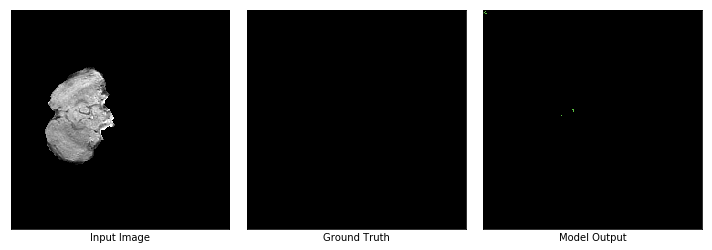

Steps: 7, Loss:1.1761687994003296
Accurary: 0.99979168176651
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9997916666667028, 0.9997916666667028, 0.9997916666667028]
Gradient min:-0.010855543427169323, max:0.008239582180976868



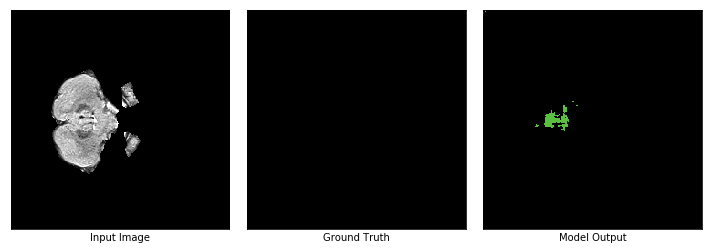

Steps: 8, Loss:1.3415299654006958
Accurary: 0.9939236044883728
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9939236111121661, 0.9939236111121661, 0.9939236111121661]
Gradient min:-0.026945820078253746, max:0.025231285020709038



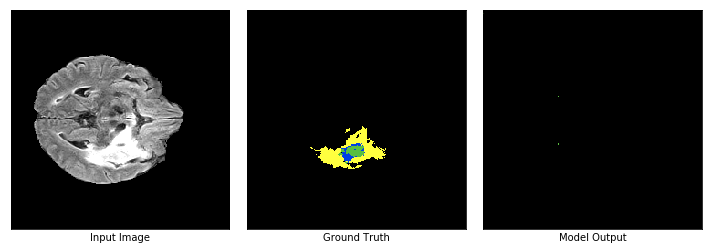

Steps: 9, Loss:1.2938637733459473
Accurary: 0.9717187285423279
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [2.7173912305056736e-08, 4.7169809095763725e-08, 6.153846115976332e-09]
Specificity: [0.9999301090299255, 0.9999302990172283, 0.9999285395265871]
Gradient min:-0.07092851400375366, max:0.05602984130382538



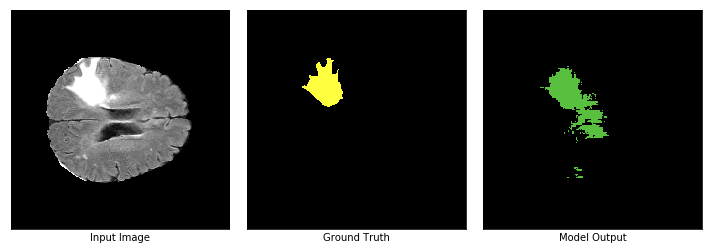

Steps: 10, Loss:1.1894980669021606
Accurary: 0.9564756751060486
Dice coefficient: [0.0, 0.0, 0.56865543]
Sensitivity: [1.0, 1.0, 0.7757009363263166]
Specificity: [0.9614756944511327, 0.9614756944511327, 0.9782832587580291]
Gradient min:-0.06928262859582901, max:0.09416675567626953



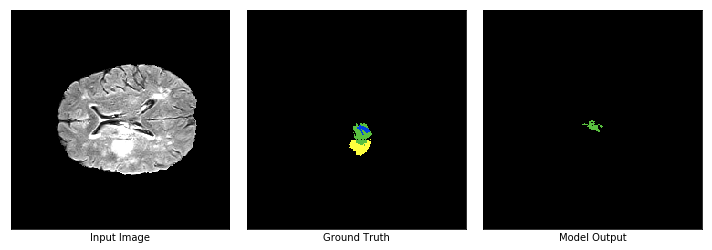

Steps: 11, Loss:1.2043296098709106
Accurary: 0.9902083277702332
Dice coefficient: [0.31363636, 0.25543478, 0.20294118]
Sensitivity: [0.2072072310147979, 0.18007665976717782, 0.12041886351799541]
Specificity: [0.9993364415807818, 0.9989535917963421, 0.9993336489734101]
Gradient min:-0.04468993470072746, max:0.023847706615924835



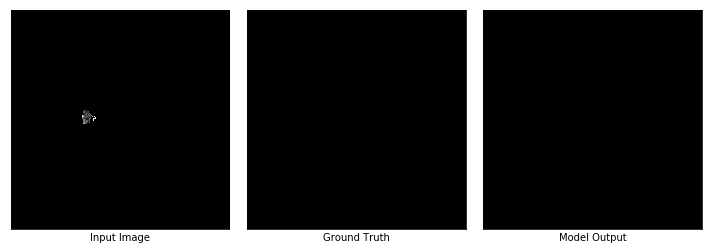

Steps: 12, Loss:1.1300352811813354
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05302301421761513, max:0.028251662850379944



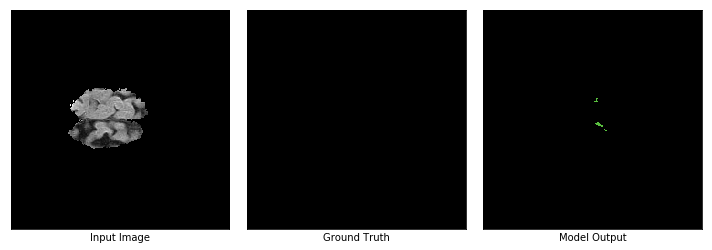

Steps: 13, Loss:1.0908139944076538
Accurary: 0.9994097352027893
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9994097222223247, 0.9994097222223247, 0.9994097222223247]
Gradient min:-0.08018898218870163, max:0.04014473780989647



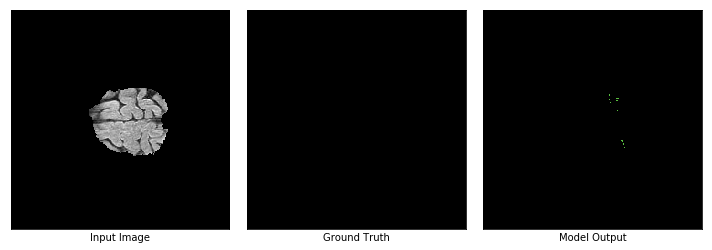

Steps: 14, Loss:1.1359095573425293
Accurary: 0.9997048377990723
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9997048611111623, 0.9997048611111623, 0.9997048611111623]
Gradient min:-0.03830431401729584, max:0.05024131014943123



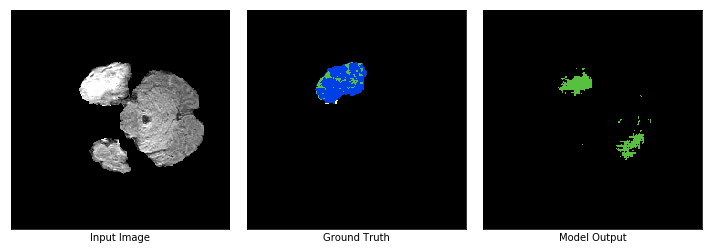

Steps: 15, Loss:1.1646597385406494
Accurary: 0.964184045791626
Dice coefficient: [0.38626933, 0.1514143, 0.38409603]
Sensitivity: [0.2949308796374949, 0.31707319452706645, 0.292404344418022]
Specificity: [0.9927860518414746, 0.9856228080914238, 0.992784114309516]
Gradient min:-0.04431524500250816, max:0.05715595558285713



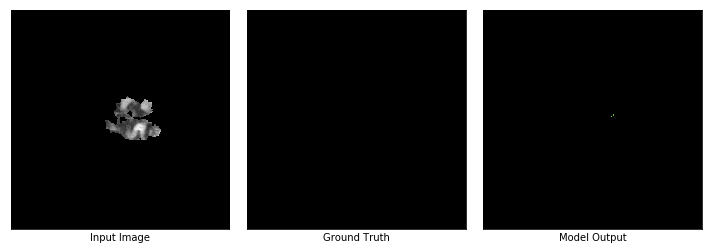

Steps: 16, Loss:1.1522809267044067
Accurary: 0.999913215637207
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9999131944444595, 0.9999131944444595, 0.9999131944444595]
Gradient min:-0.08689398318529129, max:0.051893025636672974



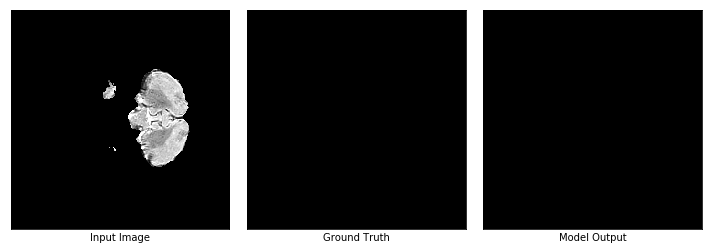

Steps: 17, Loss:1.1856416463851929
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05102115869522095, max:0.038230348378419876



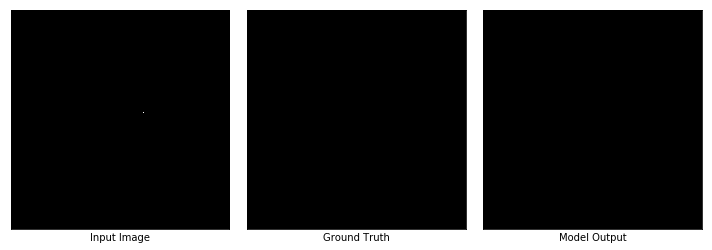

Steps: 18, Loss:1.0939112901687622
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.007176818326115608, max:0.010662410408258438



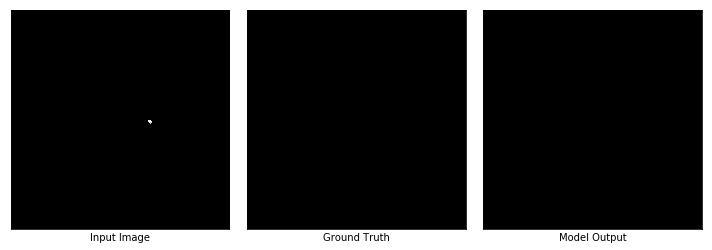

Steps: 19, Loss:1.0467711687088013
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02733810618519783, max:0.031030870974063873



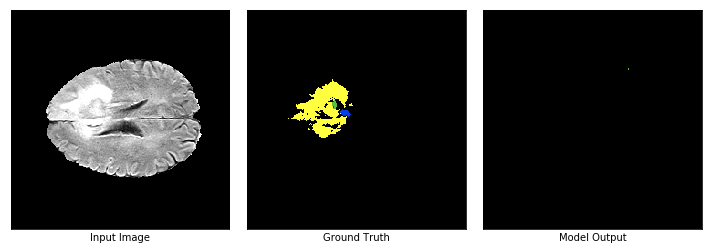

Steps: 20, Loss:1.0867177248001099
Accurary: 0.9658159613609314
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0204080591420348e-07, 2.70270197224271e-07, 5.0838840615969296e-09]
Specificity: [0.9999652186010982, 0.999965255459242, 0.9999640501141474]
Gradient min:-0.024299411103129387, max:0.031525518745183945



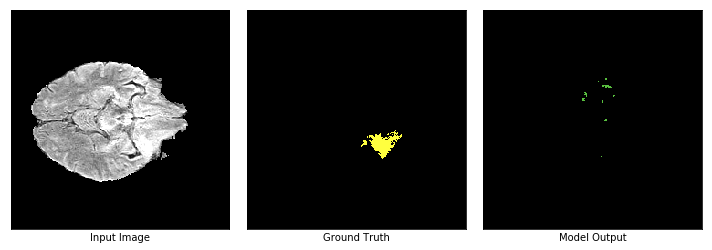

Steps: 21, Loss:1.017364740371704
Accurary: 0.9898958206176758
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.9379844585661928e-08]
Specificity: [0.9988541666668656, 0.9988541666668656, 0.9988438091235996]
Gradient min:-0.04435591772198677, max:0.04370718076825142



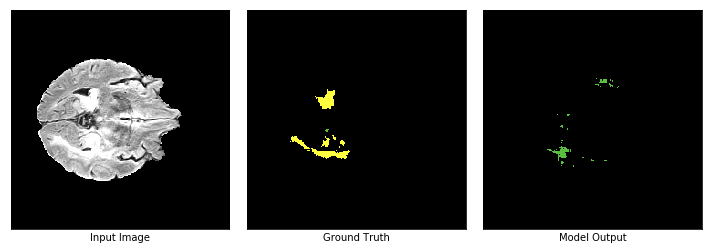

Steps: 22, Loss:1.0432472229003906
Accurary: 0.9851041436195374
Dice coefficient: [0.0, 0.0, 0.2125]
Sensitivity: [7.142852040819971e-07, 7.142852040819971e-07, 0.14305751552514004]
Specificity: [0.9957107630334264, 0.9957107630334264, 0.9974510872435792]
Gradient min:-0.03549396991729736, max:0.0431399829685688



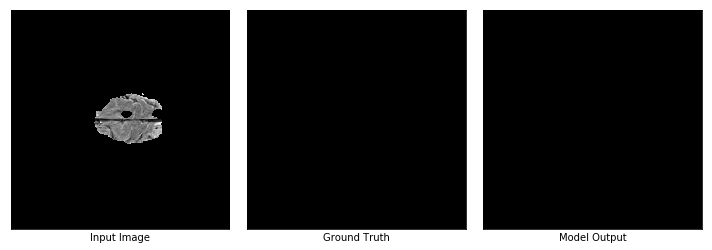

Steps: 23, Loss:0.9987061023712158
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03996803238987923, max:0.033822428435087204



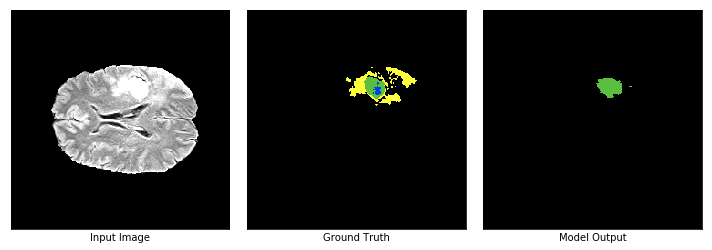

Steps: 24, Loss:1.0311428308486938
Accurary: 0.9823958277702332
Dice coefficient: [0.8732057, 0.78125, 0.49225473]
Sensitivity: [0.9217171736940107, 0.9146341489440808, 0.32924022003652936]
Specificity: [0.9986889028741541, 0.9975555245150238, 0.9998046077055963]
Gradient min:-0.006915966514497995, max:0.011563224717974663



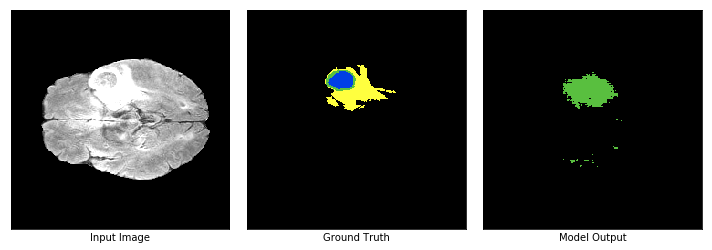

Steps: 25, Loss:1.0349791049957275
Accurary: 0.9635937213897705
Dice coefficient: [0.33920914, 0.13700235, 0.73086846]
Sensitivity: [0.5993266060719427, 0.5763547006721822, 0.6426411308334621]
Specificity: [0.9798442269270174, 0.9758175514441839, 0.9958644994253696]
Gradient min:-0.02269173599779606, max:0.025999462231993675



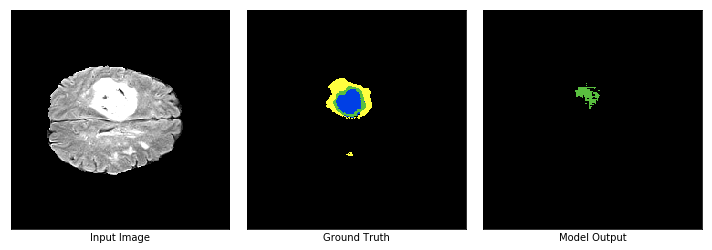

Steps: 26, Loss:1.010243535041809
Accurary: 0.9728819727897644
Dice coefficient: [0.45554614, 0.26341462, 0.31314167]
Sensitivity: [0.30707763348084893, 0.2612903464099889, 0.18563603660598882]
Specificity: [0.9993653480009581, 0.9960900680753901, 1.0]
Gradient min:-0.048471979796886444, max:0.05178758502006531



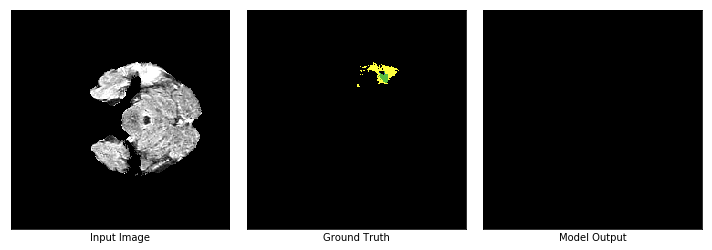

Steps: 27, Loss:0.9871314764022827
Accurary: 0.9928992986679077
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.3333331555555792e-07, 1.3698628260461884e-07, 2.4449877152814744e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.015351742506027222, max:0.01865430362522602



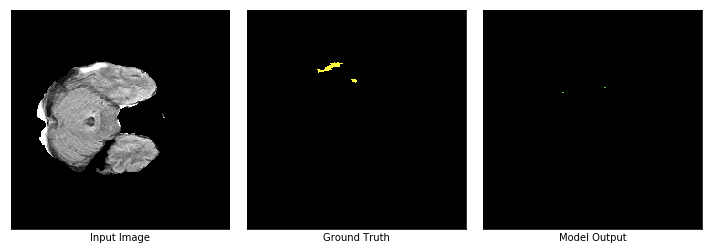

Steps: 28, Loss:0.9715896248817444
Accurary: 0.9976215362548828
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 7.575757001836591e-08]
Specificity: [0.9999131944444595, 0.9999131944444595, 0.9999129950581345]
Gradient min:-0.042956747114658356, max:0.0596495158970356



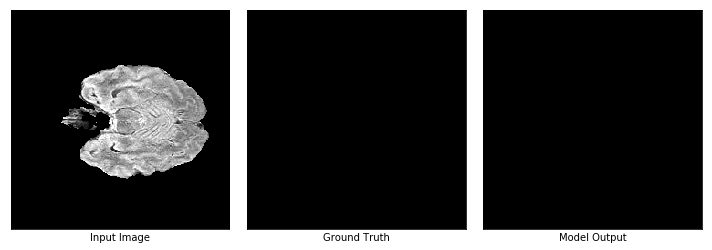

Steps: 29, Loss:0.9797490835189819
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.044864483177661896, max:0.046183571219444275



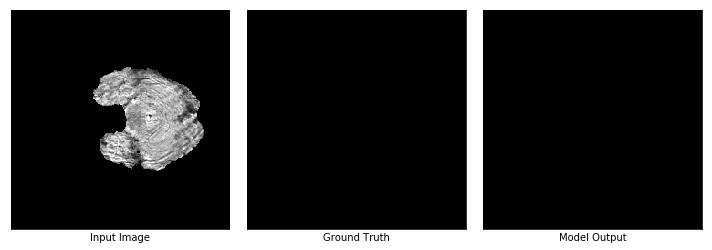

Steps: 30, Loss:0.8832036852836609
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07856296002864838, max:0.08655837178230286



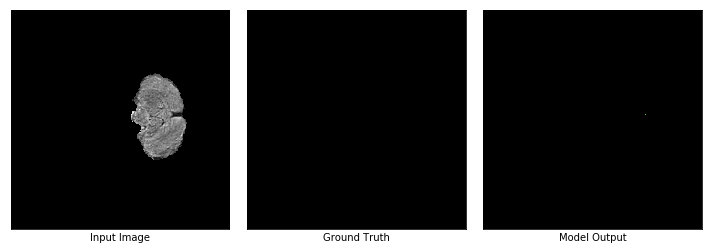

Steps: 31, Loss:1.06839919090271
Accurary: 0.9999826550483704
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9999826388888919, 0.9999826388888919, 0.9999826388888919]
Gradient min:-0.025296717882156372, max:0.03046187199652195



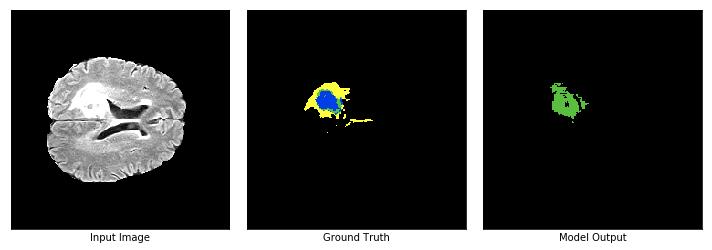

Steps: 32, Loss:1.0216655731201172
Accurary: 0.9778472185134888
Dice coefficient: [0.7312312, 0.28169015, 0.64481926]
Sensitivity: [0.8758992828075669, 0.8843537493636905, 0.5150115510776632]
Specificity: [0.9949337353630647, 0.9887560266672313, 0.998099500897302]
Gradient min:-0.09821335226297379, max:0.10972922295331955



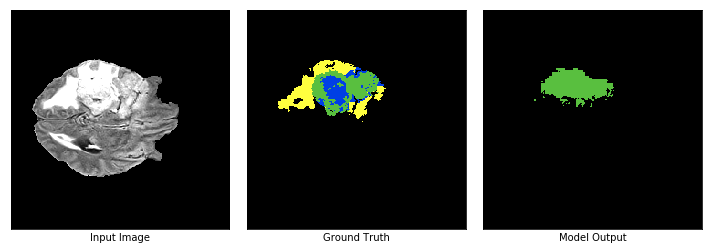

Steps: 33, Loss:0.9166940450668335
Accurary: 0.9451562762260437
Dice coefficient: [0.7522895, 0.60650223, 0.6239455]
Sensitivity: [0.6690504582079838, 0.6728855741735972, 0.4574215046207862]
Specificity: [0.9949893796643267, 0.9843191884582941, 0.9993070641996953]
Gradient min:-0.08171350508928299, max:0.08097319304943085



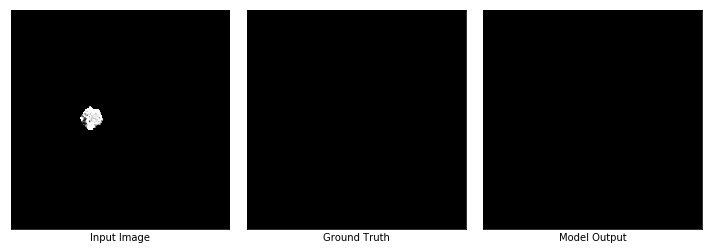

Steps: 34, Loss:1.0268877744674683
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.12533004581928253, max:0.10299994796514511



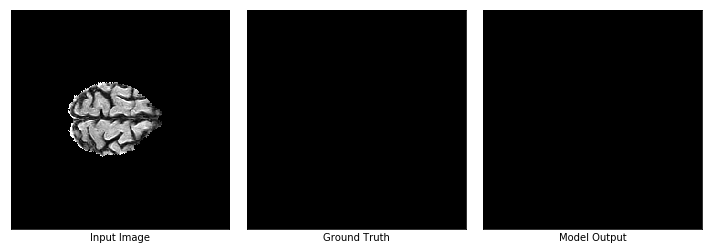

Steps: 35, Loss:0.9818742275238037
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06476493179798126, max:0.05281825736165047



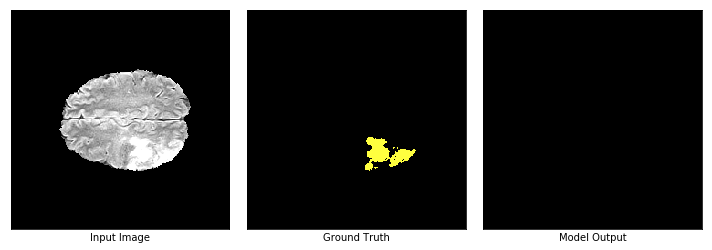

Steps: 36, Loss:0.9376267194747925
Accurary: 0.9840624928474426
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0893246068701025e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.020823059603571892, max:0.01868078112602234



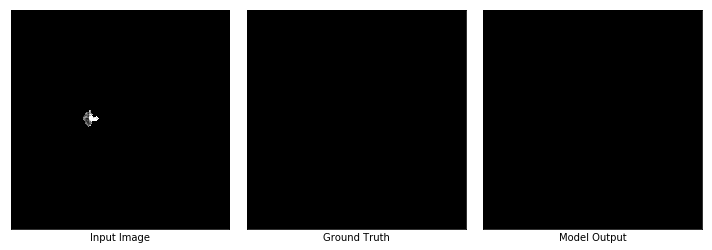

Steps: 37, Loss:0.906348705291748
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04840029031038284, max:0.05573660880327225



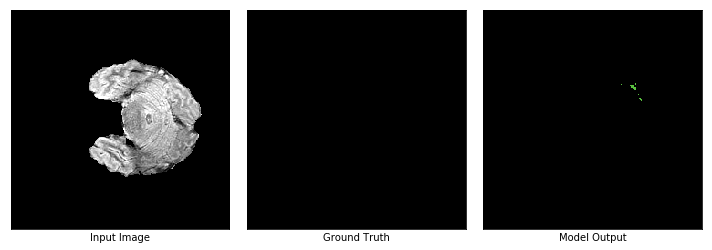

Steps: 38, Loss:0.9663647413253784
Accurary: 0.9993749856948853
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9993750000001085, 0.9993750000001085, 0.9993750000001085]
Gradient min:-0.02822815254330635, max:0.026712842285633087



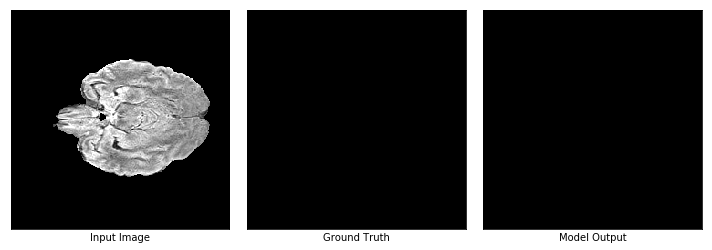

Steps: 39, Loss:0.9110151529312134
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.026206806302070618, max:0.029471468180418015



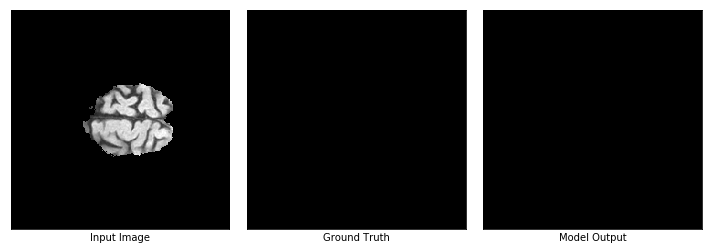

Steps: 40, Loss:1.0176948308944702
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.13094781339168549, max:0.1150803193449974



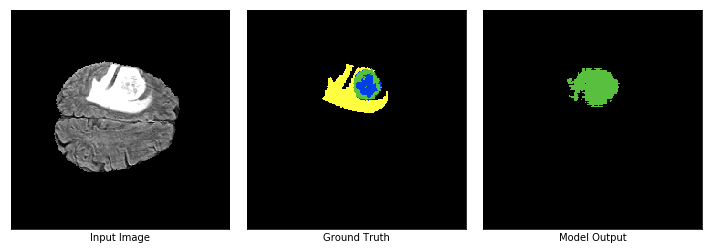

Steps: 41, Loss:0.9171873331069946
Accurary: 0.9630382061004639
Dice coefficient: [0.6721718, 0.408933, 0.72150946]
Sensitivity: [0.978365384875416, 0.9694117654256055, 0.6012578633070949]
Specificity: [0.9863303269471656, 0.9793965894220557, 0.9971746807937744]
Gradient min:-0.027961811050772667, max:0.027677113190293312



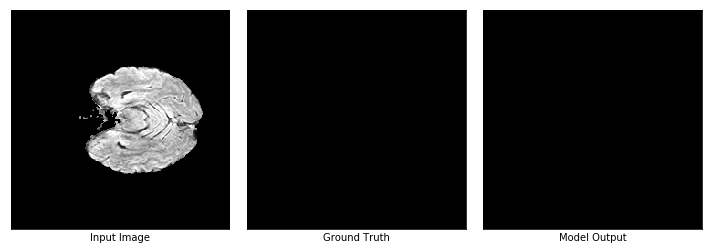

Steps: 42, Loss:0.9615028500556946
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0808798223733902, max:0.0860515832901001



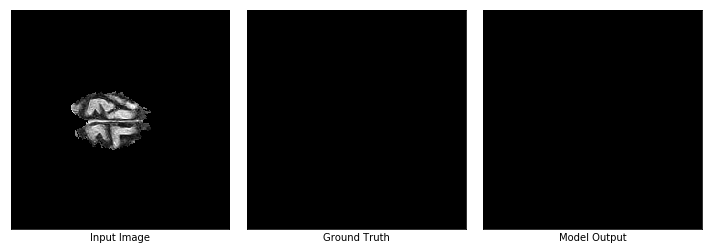

Steps: 43, Loss:0.9565681219100952
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.01095489040017128, max:0.014898203313350677



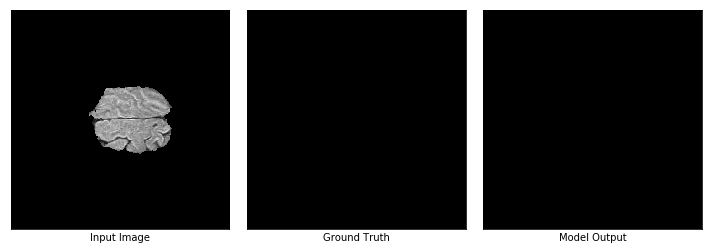

Steps: 44, Loss:0.8552794456481934
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06926721334457397, max:0.04077873006463051



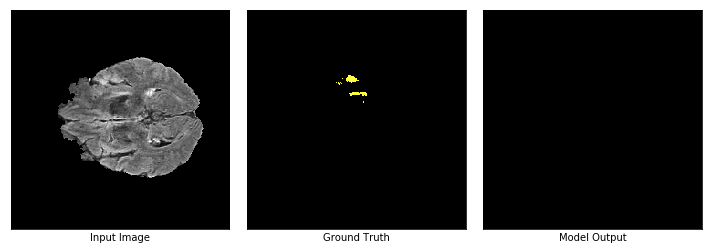

Steps: 45, Loss:0.8862149715423584
Accurary: 0.9975000023841858
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 6.944443962191392e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07465875148773193, max:0.05321190506219864



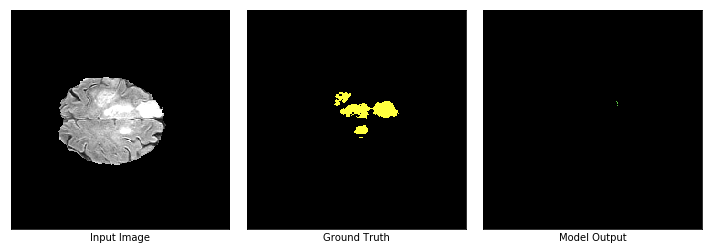

Steps: 46, Loss:0.9297352433204651
Accurary: 0.9823784828186035
Dice coefficient: [0.0, 0.0, 0.003933137]
Sensitivity: [1.0, 1.0, 0.0019743435145671913]
Specificity: [0.9999305555555676, 0.9999305555555676, 0.9999646561931248]
Gradient min:-0.04073140025138855, max:0.04082977771759033



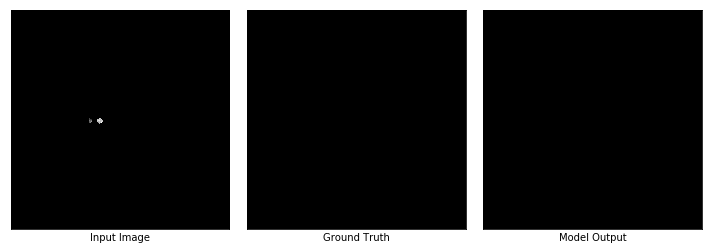

Steps: 47, Loss:0.9444518685340881
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.035883478820323944, max:0.03866768255829811



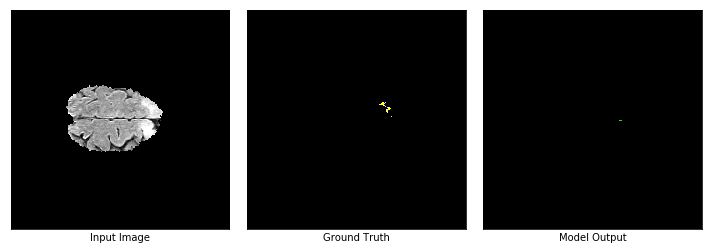

Steps: 48, Loss:0.8877029418945312
Accurary: 0.9992014169692993
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 2.3255808545160803e-07]
Specificity: [0.9999479166666757, 0.9999479166666757, 0.9999478777559727]
Gradient min:-0.05187618359923363, max:0.03831929340958595



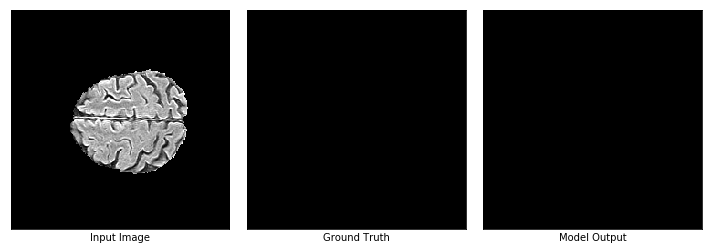

Steps: 49, Loss:0.8949942588806152
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04062408208847046, max:0.05629778653383255



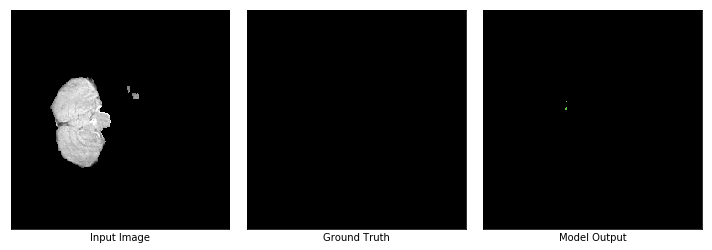

Steps: 50, Loss:0.8840844631195068
Accurary: 0.9998611211776733
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9998611111111352, 0.9998611111111352, 0.9998611111111352]
Gradient min:-0.16468843817710876, max:0.13545456528663635



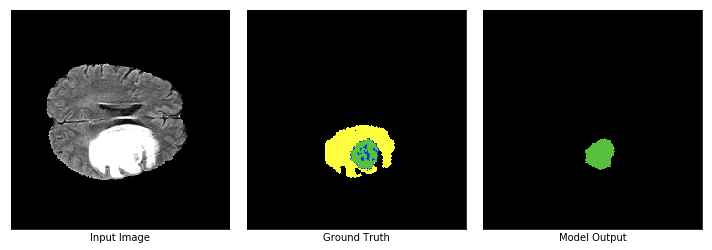

Steps: 51, Loss:1.0394648313522339
Accurary: 0.9551388621330261
Dice coefficient: [0.93075484, 0.8440111, 0.40539864]
Sensitivity: [0.9431099880769913, 0.9711538466161242, 0.25431169879488336]
Specificity: [0.9988382122553049, 0.9963844425729457, 0.9999816213633307]
Gradient min:-0.1126544401049614, max:0.13125687837600708



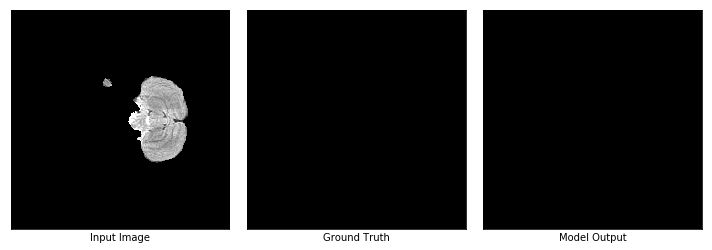

Steps: 52, Loss:0.8458539843559265
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.09909981489181519, max:0.11855209618806839



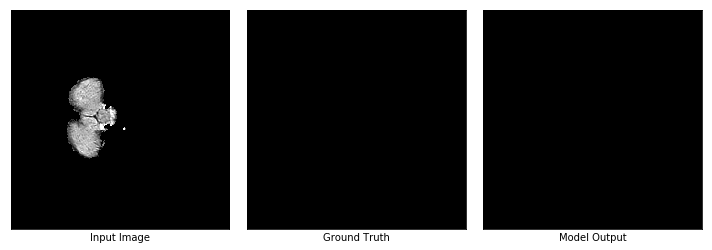

Steps: 53, Loss:1.0255813598632812
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15819841623306274, max:0.15608373284339905



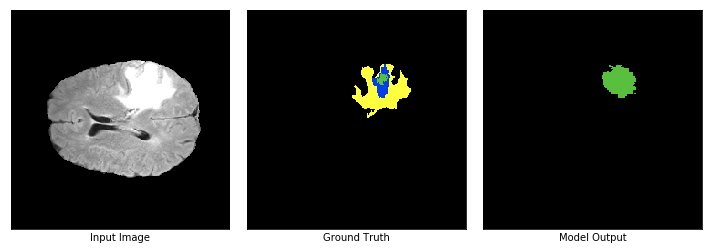

Steps: 54, Loss:0.9127909541130066
Accurary: 0.9643576145172119
Dice coefficient: [0.5873715, 0.17021276, 0.542546]
Sensitivity: [0.9615384624630178, 1.0, 0.40010040461796986]
Specificity: [0.9904518746519215, 0.9850813743244746, 0.9973205294207091]
Gradient min:-0.06841198354959488, max:0.06117876619100571



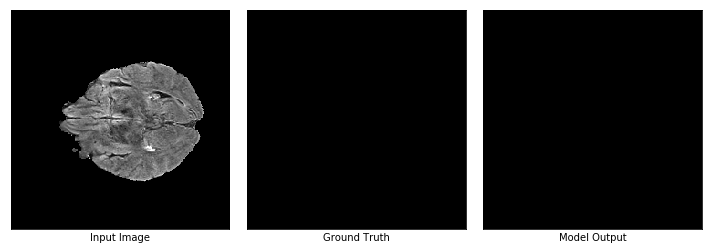

Steps: 55, Loss:0.9459697008132935
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15040458738803864, max:0.17057140171527863



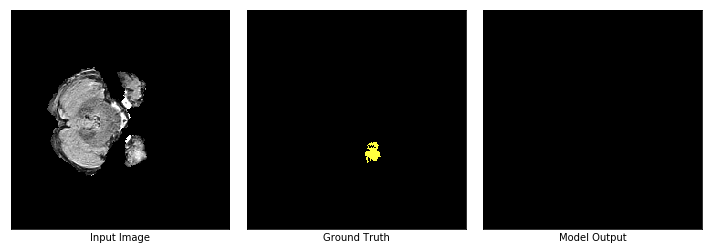

Steps: 56, Loss:0.9198009967803955
Accurary: 0.9958680272102356
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 4.2016804957277106e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0929345190525055, max:0.10582686960697174



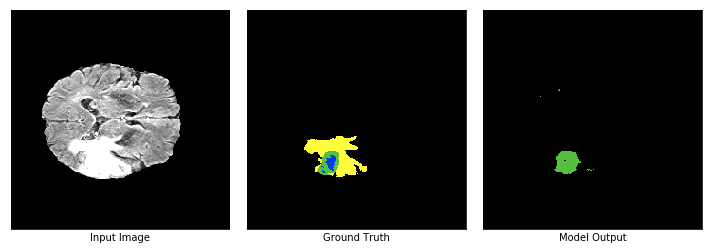

Steps: 57, Loss:1.0158344507217407
Accurary: 0.9734027981758118
Dice coefficient: [0.84325397, 0.6878547, 0.4501689]
Sensitivity: [0.9159482776735285, 0.8991097952786411, 0.2922149161611024]
Specificity: [0.9979172500703729, 0.9957913486901155, 0.999802782558842]
Gradient min:-0.04948866739869118, max:0.04531073570251465



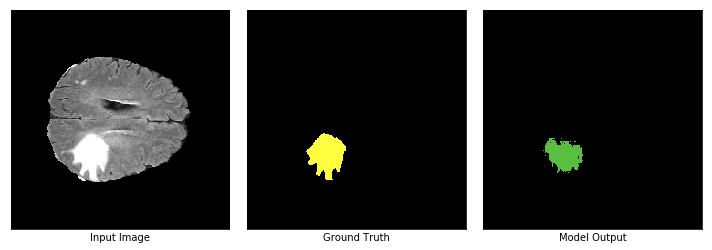

Steps: 58, Loss:1.0312135219573975
Accurary: 0.9744965434074402
Dice coefficient: [0.0, 0.0, 0.7758333]
Sensitivity: [1.0, 1.0, 0.6830520933011586]
Specificity: [0.9819965277809034, 0.9819965277809034, 0.9981151199391655]
Gradient min:-0.14130251109600067, max:0.13358454406261444



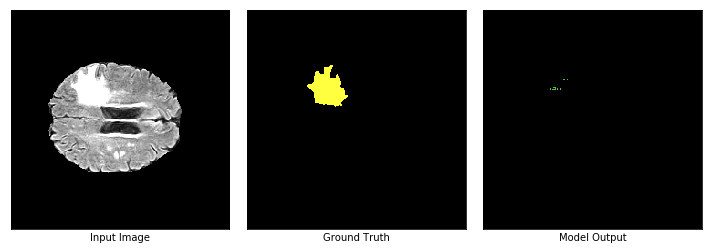

Steps: 59, Loss:0.8260676860809326
Accurary: 0.9799826145172119
Dice coefficient: [0.0, 0.0, 0.02905983]
Sensitivity: [1.0, 1.0, 0.014744154252002132]
Specificity: [0.9997048611111623, 0.9997048611111623, 1.0]
Gradient min:-0.05585670471191406, max:0.050060439854860306



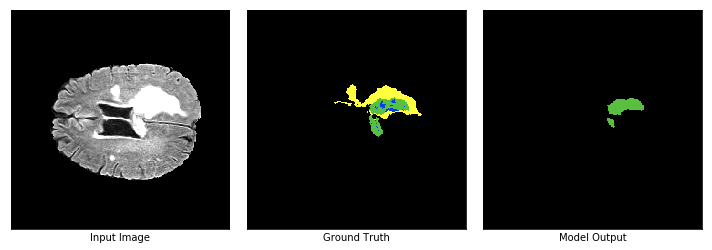

Steps: 60, Loss:0.8663668632507324
Accurary: 0.9763715267181396
Dice coefficient: [0.8005997, 0.7358185, 0.4651163]
Sensitivity: [0.6837388004642919, 0.6666666715614292, 0.30353201267366436]
Specificity: [0.9996656048153495, 0.9982606862386443, 0.9999462249946321]
Gradient min:-0.12540727853775024, max:0.1271083503961563



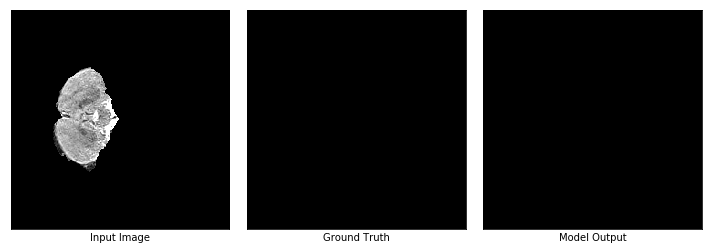

Steps: 61, Loss:0.8545849919319153
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03956809639930725, max:0.041209373623132706



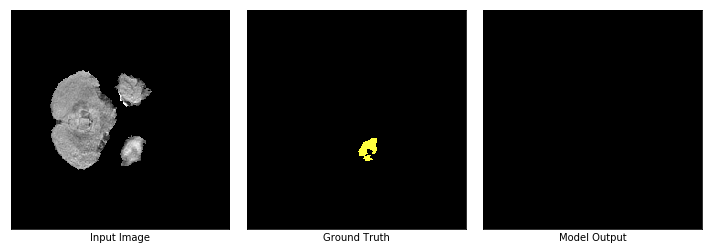

Steps: 62, Loss:0.9205292463302612
Accurary: 0.9947742819786072
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 3.3222590258385714e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0805448442697525, max:0.08957847952842712



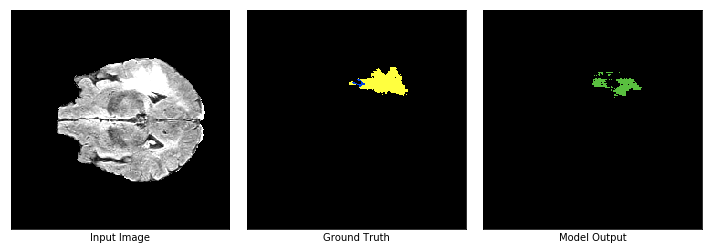

Steps: 63, Loss:0.9325499534606934
Accurary: 0.9810763597488403
Dice coefficient: [0.09944751, 0.0, 0.5638999]
Sensitivity: [0.7714286367346751, 1.0, 0.4237623819429467]
Specificity: [0.9916442282651534, 0.9911805555570867, 0.9985863226721]
Gradient min:-0.1409604847431183, max:0.14650435745716095



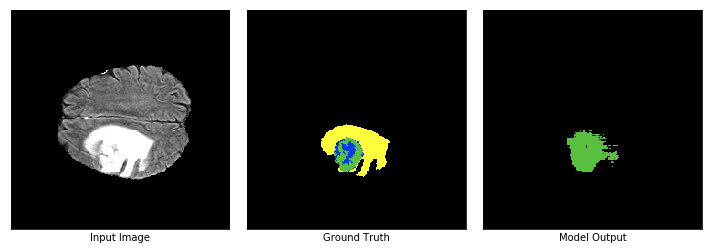

Steps: 64, Loss:0.976752519607544
Accurary: 0.9598958492279053
Dice coefficient: [0.72483224, 0.53055286, 0.6733225]
Sensitivity: [0.9863013700193908, 0.9873646211667035, 0.5180421596354334]
Specificity: [0.988646780906028, 0.9831539459413186, 0.9989416251530188]
Gradient min:-0.12261739373207092, max:0.13625085353851318



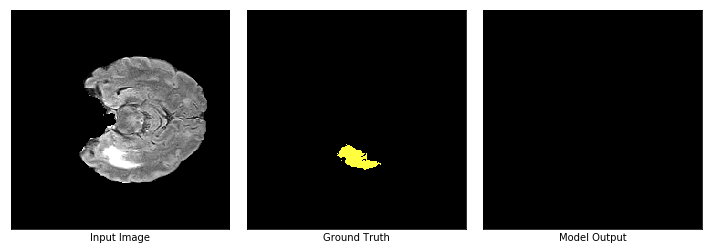

Steps: 65, Loss:0.8278673887252808
Accurary: 0.9892361164093018
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.6129031997918842e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.17861856520175934, max:0.19853678345680237



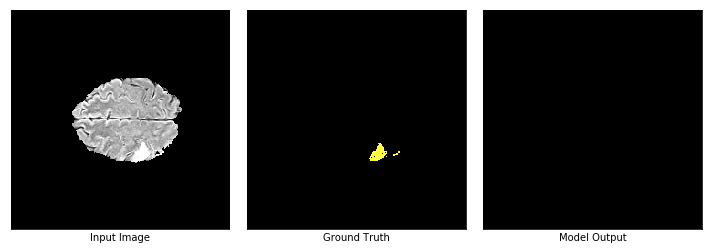

Steps: 66, Loss:0.8183627724647522
Accurary: 0.99609375
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 4.4444442469135894e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.13144929707050323, max:0.12091949582099915



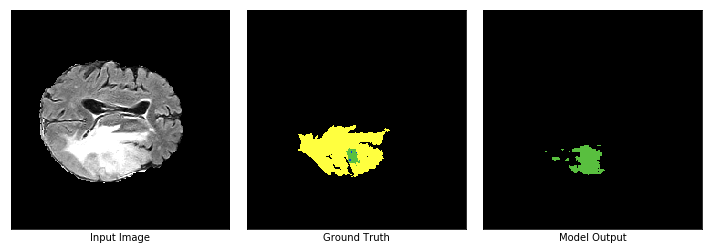

Steps: 67, Loss:0.896386981010437
Accurary: 0.9401562213897705
Dice coefficient: [0.3489279, 0.33267716, 0.3511172]
Sensitivity: [1.0, 1.0, 0.21757558853468326]
Specificity: [0.9883666254526451, 0.988194529089134, 0.9985756830249948]
Gradient min:-0.01961139403283596, max:0.016990281641483307



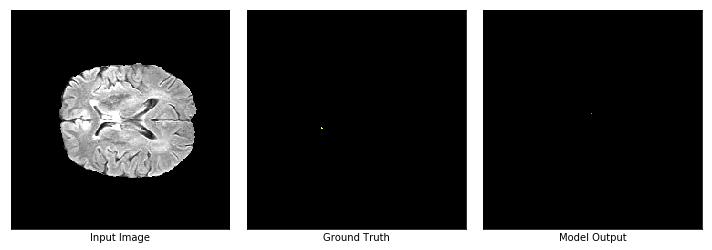

Steps: 68, Loss:0.9859327077865601
Accurary: 0.9999305605888367
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 3.3333222222592593e-06]
Specificity: [0.9999826388888919, 0.9999826388888919, 0.9999826379846203]
Gradient min:-0.19993314146995544, max:0.19642478227615356



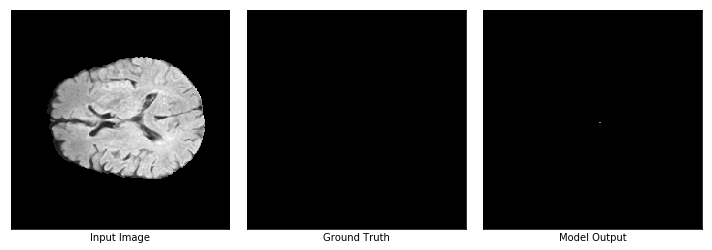

Steps: 69, Loss:0.9135817289352417
Accurary: 0.999965250492096
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9999652777777838, 0.9999652777777838, 0.9999652777777838]
Gradient min:-0.21801486611366272, max:0.2174490988254547



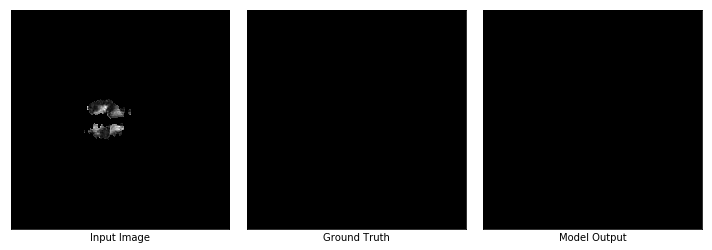

Steps: 70, Loss:0.9862709641456604
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.364591121673584, max:0.3743569552898407



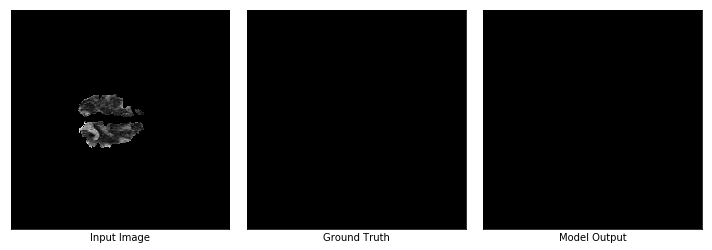

Steps: 71, Loss:0.8746414184570312
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.4014461040496826, max:0.4592430293560028



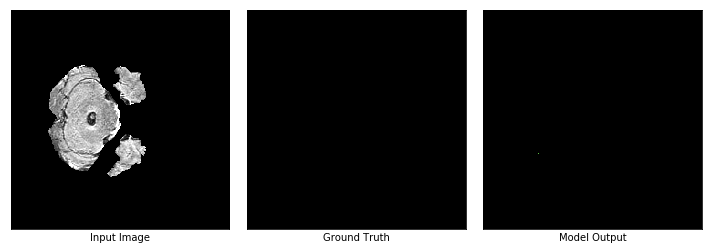

Steps: 72, Loss:0.9984623193740845
Accurary: 0.9999826550483704
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9999826388888919, 0.9999826388888919, 0.9999826388888919]
Gradient min:-0.23480269312858582, max:0.23055602610111237



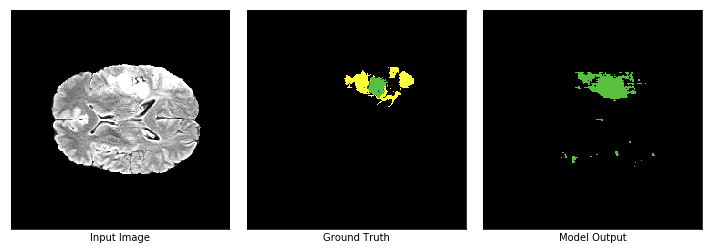

Steps: 73, Loss:1.0328327417373657
Accurary: 0.9756944179534912
Dice coefficient: [0.4181705, 0.39823568, 0.6397146]
Sensitivity: [0.9940828404117503, 0.9937106920216764, 0.6435406726990377]
Specificity: [0.9837064720087132, 0.9833630110709537, 0.9918006602080359]
Gradient min:-0.21073046326637268, max:0.20476846396923065



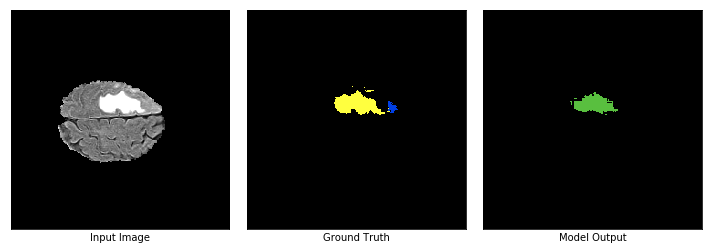

Steps: 74, Loss:1.0562818050384521
Accurary: 0.9823784828186035
Dice coefficient: [0.0, 0.0, 0.7741546]
Sensitivity: [1.2345677488187964e-07, 9.99990000099999e-06, 0.6554192264272063]
Specificity: [0.9882125906242785, 0.988228962310417, 0.9993465437463624]
Gradient min:-0.23222294449806213, max:0.2407543659210205



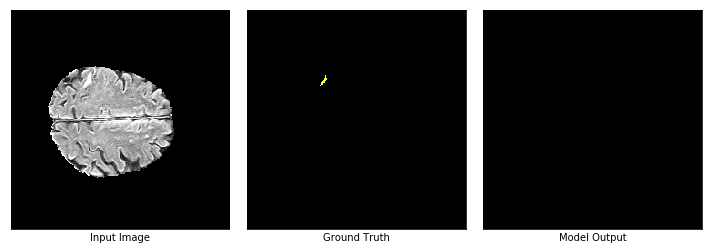

Steps: 75, Loss:0.9230969548225403
Accurary: 0.999461829662323
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 3.2258054110305127e-07]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.12778355181217194, max:0.13420848548412323



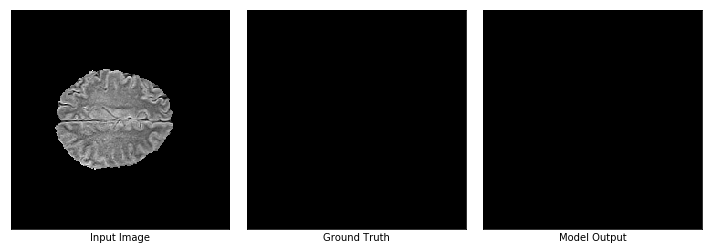

Steps: 76, Loss:0.9311750531196594
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.4078177213668823, max:0.4334636330604553



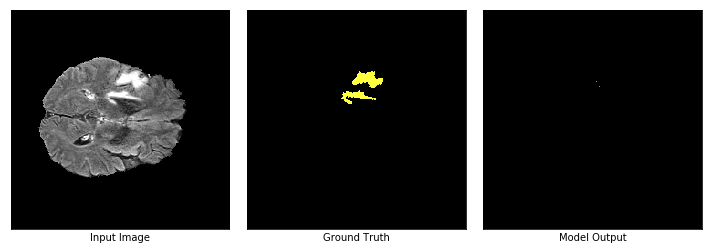

Steps: 77, Loss:0.8523714542388916
Accurary: 0.9901736378669739
Dice coefficient: [0.0, 0.0, 0.0035273368]
Sensitivity: [1.0, 1.0, 0.0017699291722136432]
Specificity: [0.9999652777777838, 0.9999652777777838, 0.9999824669062887]
Gradient min:-0.056085407733917236, max:0.06173776462674141



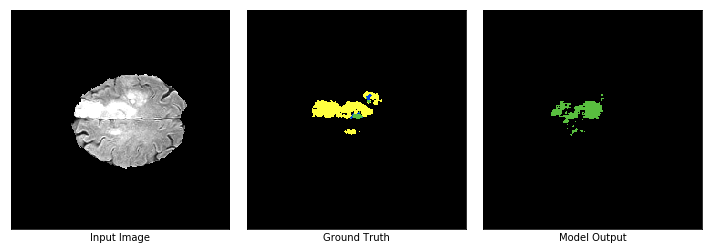

Steps: 78, Loss:0.9075962901115417
Accurary: 0.9770659804344177
Dice coefficient: [0.13937283, 0.11192214, 0.62058526]
Sensitivity: [0.600000039999996, 0.7540984009674753, 0.5036855077503234]
Specificity: [0.9878086956542942, 0.9875736457033363, 0.9974103832992053]
Gradient min:-0.24621915817260742, max:0.2499575912952423



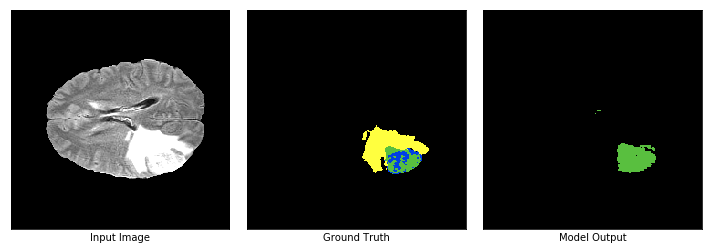

Steps: 79, Loss:0.8156054615974426
Accurary: 0.9640972018241882
Dice coefficient: [0.8213573, 0.63883847, 0.5597781]
Sensitivity: [0.8802139050244502, 0.904109590683055, 0.3978706648348948]
Specificity: [0.9956586958447615, 0.9905114353882224, 0.9989103588553483]
Gradient min:-0.09694764018058777, max:0.11012781411409378



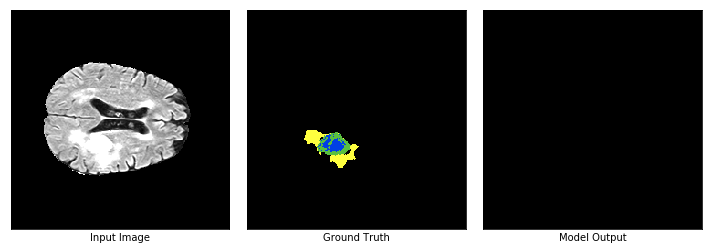

Steps: 80, Loss:0.8741135597229004
Accurary: 0.9784722328186035
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.526717533943244e-08, 2.5641024983563467e-08, 8.064516063995838e-09]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05460159108042717, max:0.05769340693950653



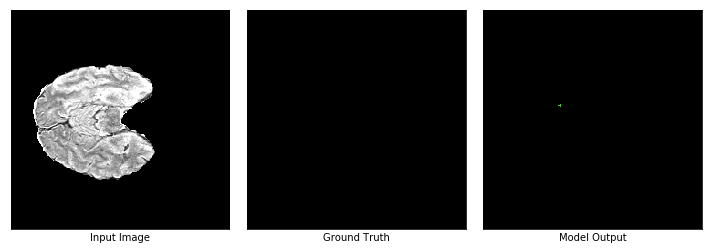

Steps: 81, Loss:0.9376046061515808
Accurary: 0.9998611211776733
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9998611111111352, 0.9998611111111352, 0.9998611111111352]
Gradient min:-0.27236849069595337, max:0.28449010848999023



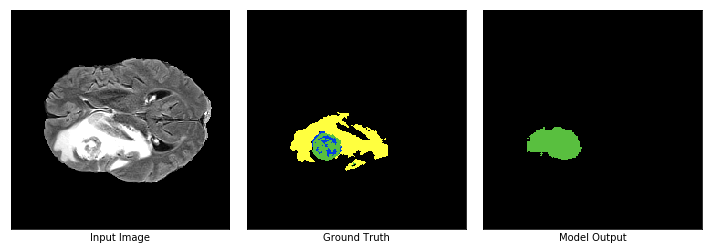

Steps: 82, Loss:0.9794264435768127
Accurary: 0.948437511920929
Dice coefficient: [0.6587537, 0.51594746, 0.6003976]
Sensitivity: [0.9724655823220828, 0.961538462210866, 0.43515850306870746]
Specificity: [0.98621503142793, 0.9822894017005174, 0.9990762978017594]
Gradient min:-0.07107111066579819, max:0.04483330622315407



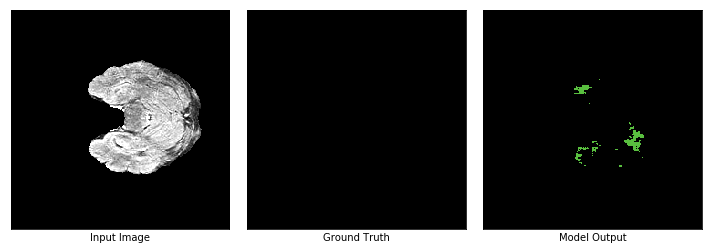

Steps: 83, Loss:0.9459741711616516
Accurary: 0.9917708039283752
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.991770833334762, 0.991770833334762, 0.991770833334762]
Gradient min:-0.2570573091506958, max:0.275688499212265



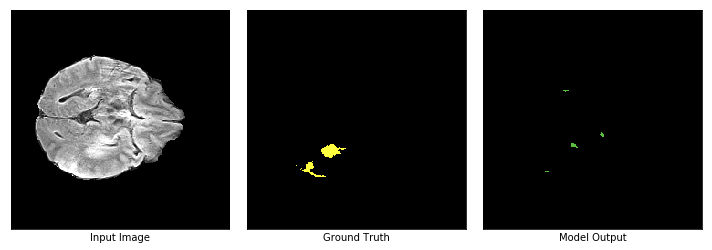

Steps: 84, Loss:0.8413087129592896
Accurary: 0.9932118058204651
Dice coefficient: [0.0, 0.0, 0.015228426]
Sensitivity: [1.0, 1.0, 0.008823558564012984]
Specificity: [0.9990625000001627, 0.9990625000001627, 0.9991093258820976]
Gradient min:-0.12162119150161743, max:0.12100597470998764



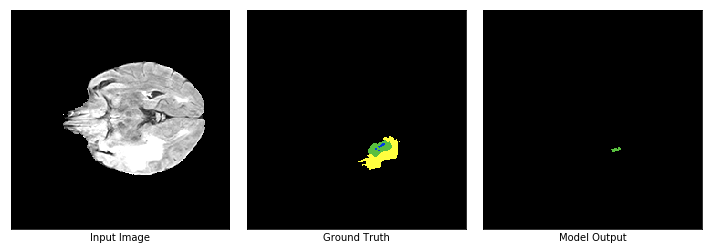

Steps: 85, Loss:0.9219070672988892
Accurary: 0.9858333468437195
Dice coefficient: [0.23417722, 0.21232876, 0.08371041]
Sensitivity: [0.13261651854421083, 0.12156866189926815, 0.043683600428765054]
Specificity: [1.0, 0.9998953701281899, 1.0]
Gradient min:-0.21053524315357208, max:0.21848584711551666



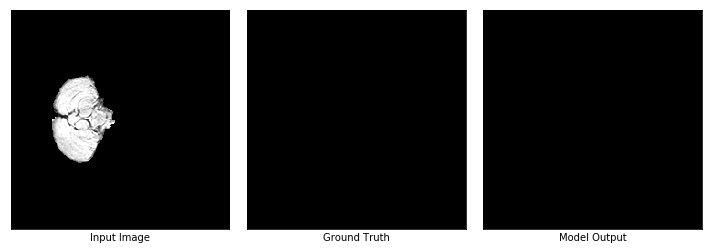

Steps: 86, Loss:0.9032119512557983
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.20728948712348938, max:0.20222114026546478



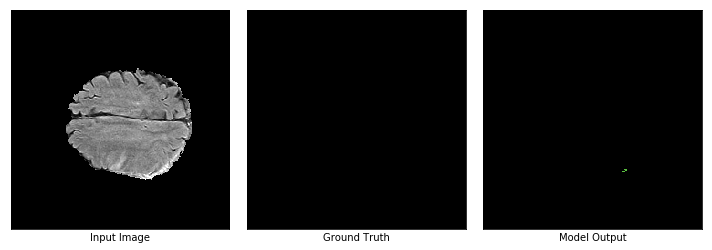

Steps: 87, Loss:0.7576265931129456
Accurary: 0.9997742772102356
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9997743055555948, 0.9997743055555948, 0.9997743055555948]
Gradient min:-0.07301735877990723, max:0.067109115421772



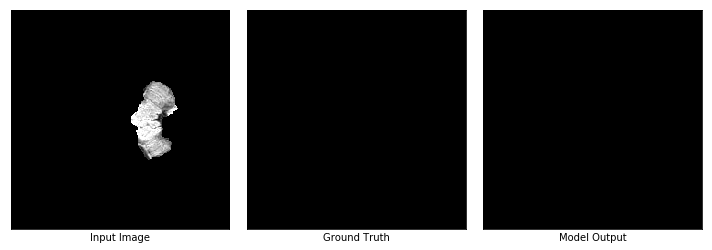

Steps: 88, Loss:0.8678082823753357
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.025004524737596512, max:0.03940804675221443



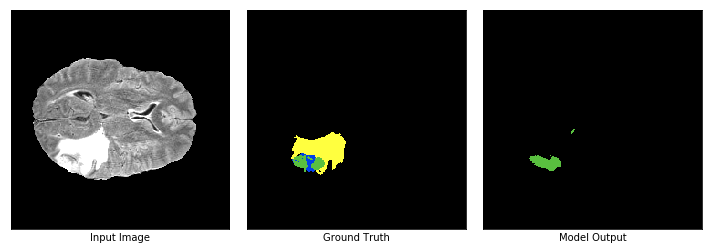

Steps: 89, Loss:0.9021927714347839
Accurary: 0.9716492891311646
Dice coefficient: [0.81693363, 0.76048714, 0.33129904]
Sensitivity: [0.7484276782300276, 0.8216374321158646, 0.20031629309269217]
Specificity: [0.9992997566655638, 0.9979740822246719, 0.9996948099743829]
Gradient min:-0.1260056495666504, max:0.11929033696651459



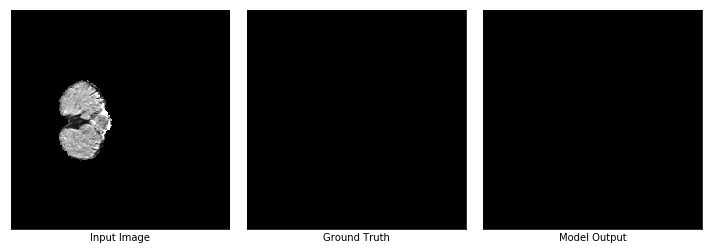

Steps: 90, Loss:0.717693567276001
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0937744677066803, max:0.10079357773065567



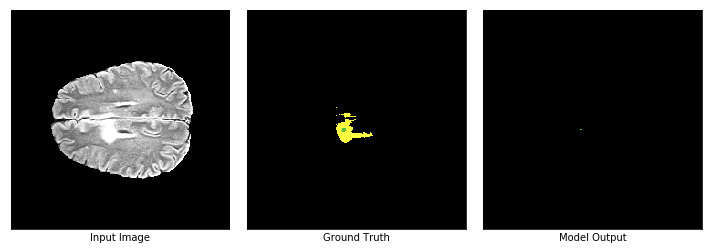

Steps: 91, Loss:0.9311375617980957
Accurary: 0.9915624856948853
Dice coefficient: [0.2962963, 0.2962963, 0.016194332]
Sensitivity: [0.17391340264634667, 0.17391340264634667, 0.00816328554768805]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07778134942054749, max:0.09224501997232437



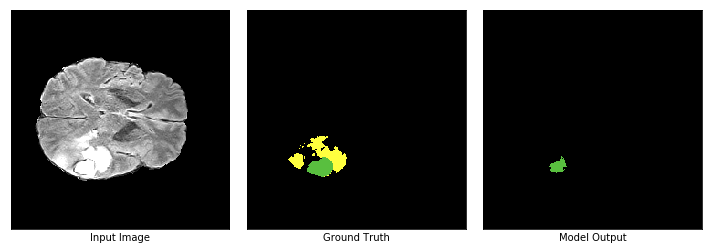

Steps: 92, Loss:0.9957186579704285
Accurary: 0.980138897895813
Dice coefficient: [0.63141525, 0.63141525, 0.26417527]
Sensitivity: [0.46347033188423903, 0.46347033188423903, 0.15219005826139526]
Specificity: [0.9999650117210795, 0.9999650117210795, 1.0]
Gradient min:-0.21919642388820648, max:0.24525226652622223



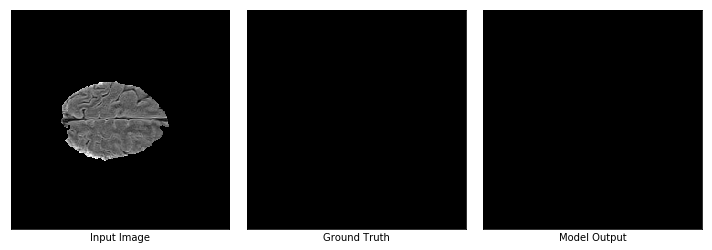

Steps: 93, Loss:0.8323559761047363
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.2581309676170349, max:0.33208733797073364



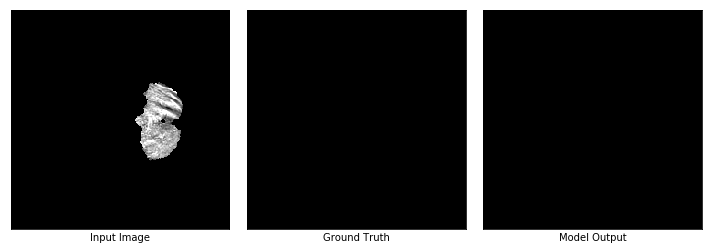

Steps: 94, Loss:0.9165818691253662
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.3358776569366455, max:0.3250768184661865



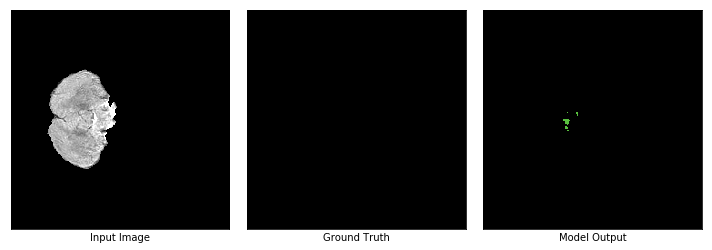

Steps: 95, Loss:0.997846245765686
Accurary: 0.9992534518241882
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9992534722223518, 0.9992534722223518, 0.9992534722223518]
Gradient min:-0.24479974806308746, max:0.2669575810432434



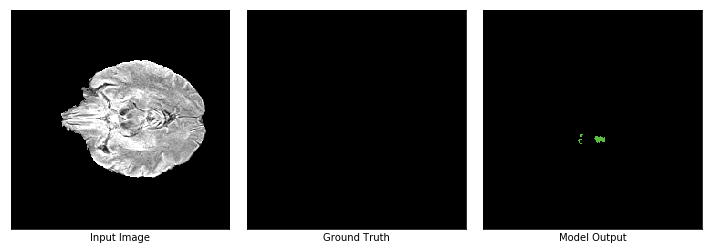

Steps: 96, Loss:0.8663138151168823
Accurary: 0.9984895586967468
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9984895833335956, 0.9984895833335956, 0.9984895833335956]
Gradient min:-0.23657864332199097, max:0.25143468379974365



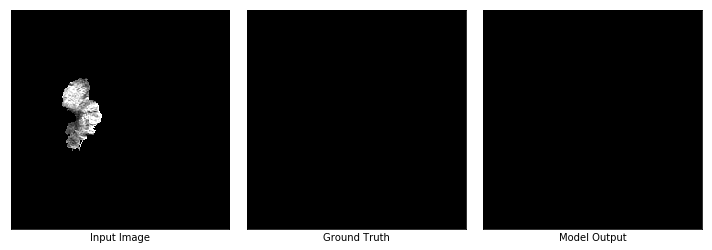

Steps: 97, Loss:0.9890623092651367
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.19794286787509918, max:0.22132612764835358



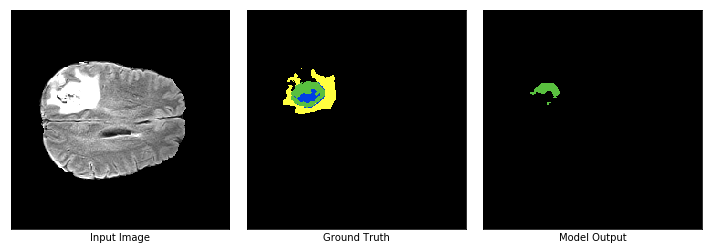

Steps: 98, Loss:0.9422906637191772
Accurary: 0.9726389050483704
Dice coefficient: [0.52213186, 0.6251442, 0.27059925]
Sensitivity: [0.3533007414021914, 0.4688581406771948, 0.15646995583936135]
Specificity: [1.0, 0.999684332363003, 1.0]
Gradient min:-0.2045474797487259, max:0.21869151294231415



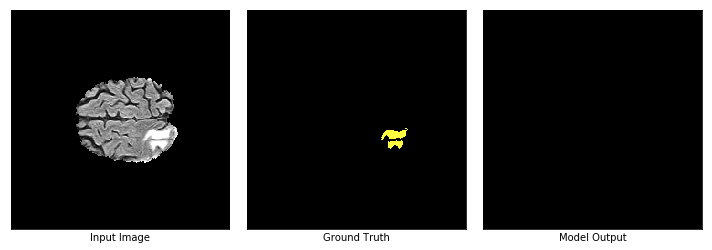

Steps: 99, Loss:1.0814179182052612
Accurary: 0.9948784708976746
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 3.389830393565072e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.25780189037323, max:0.2576987147331238



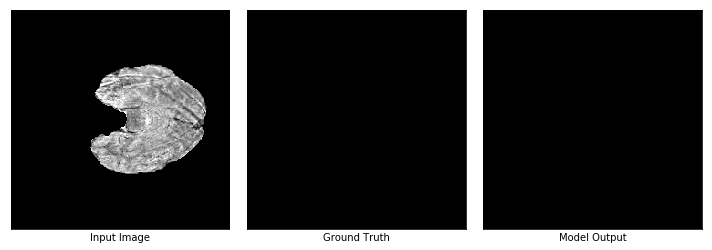

Steps: 100, Loss:0.7856161594390869
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04673178493976593, max:0.031511928886175156



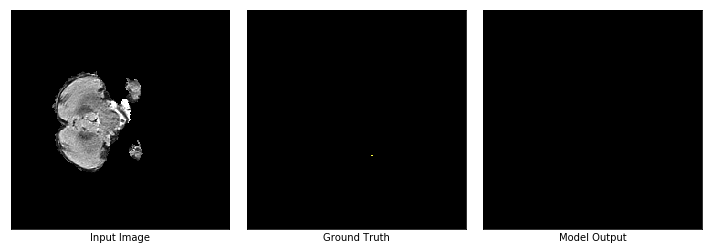

Steps: 101, Loss:0.8737177848815918
Accurary: 0.999965250492096
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 4.9999750001249995e-06]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.1665685772895813, max:0.15557405352592468



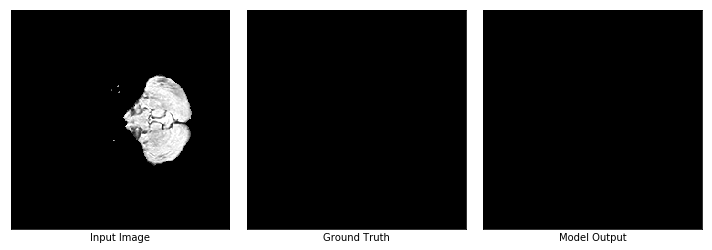

Steps: 102, Loss:0.8325589895248413
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15787893533706665, max:0.17070497572422028



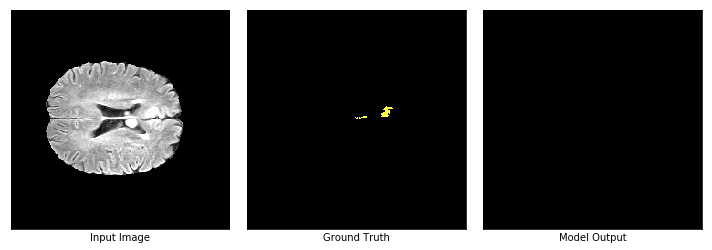

Steps: 103, Loss:0.9552826881408691
Accurary: 0.9981597065925598
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 9.433961374154588e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03409266471862793, max:0.030800336971879005



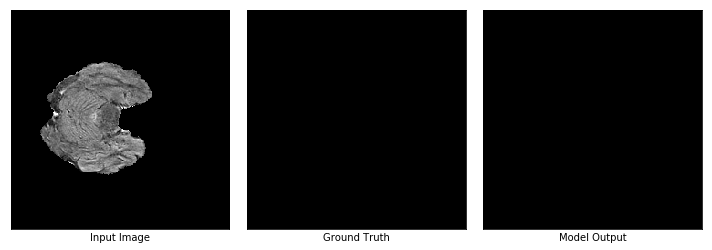

Steps: 104, Loss:0.9465173482894897
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.02473631501197815, max:0.025678517296910286



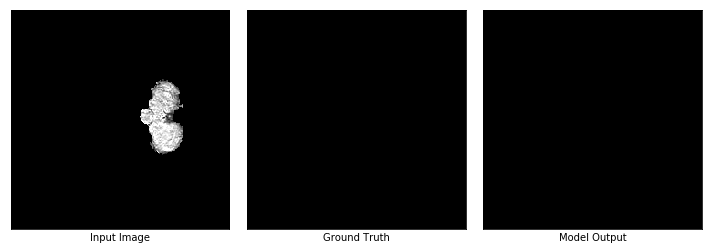

Steps: 105, Loss:0.8109986782073975
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07150113582611084, max:0.07735376805067062



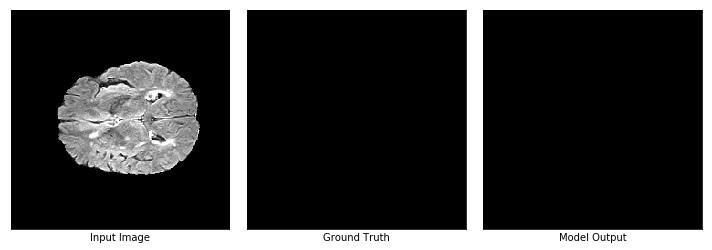

Steps: 106, Loss:0.9604051113128662
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.10582376271486282, max:0.07405887544155121



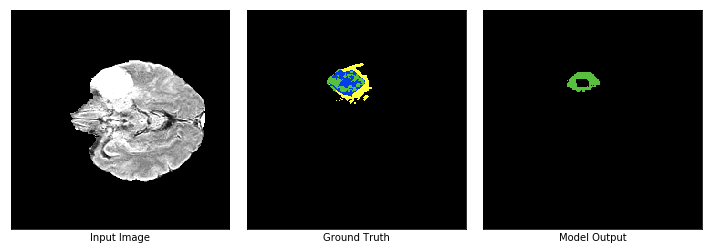

Steps: 107, Loss:0.8643033504486084
Accurary: 0.9823784828186035
Dice coefficient: [0.73058635, 0.6317044, 0.5295807]
Sensitivity: [0.5755305920657854, 0.701058208966714, 0.36015625499877923]
Specificity: [1.0, 0.9965747439801869, 1.0]
Gradient min:-0.05222214013338089, max:0.05972271412611008



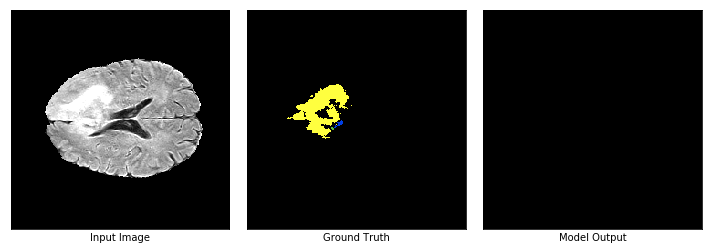

Steps: 108, Loss:0.8427597284317017
Accurary: 0.9701215028762817
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [2.8571420408165597e-07, 1.4285693877580176e-06, 5.810575213186664e-09]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05664040148258209, max:0.06126420199871063



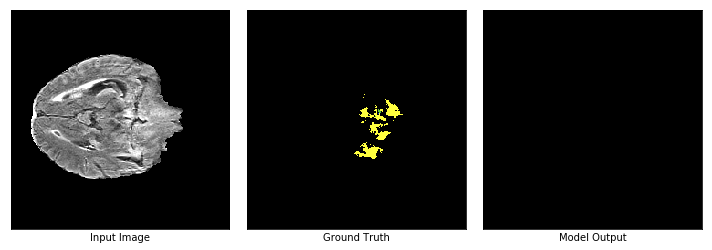

Steps: 109, Loss:0.8824816346168518
Accurary: 0.9860416650772095
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [8.333326388894677e-07, 9.99999000001e-07, 1.2437810790574495e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.04866465926170349, max:0.046879637986421585



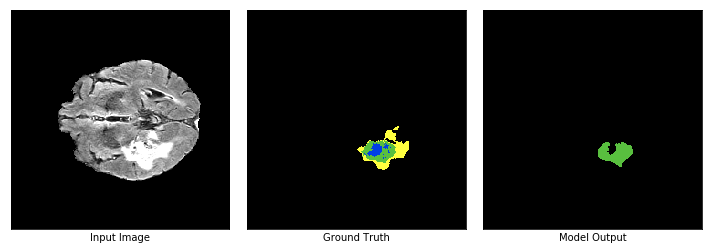

Steps: 110, Loss:0.7763255834579468
Accurary: 0.9856423735618591
Dice coefficient: [0.8212025, 0.7755102, 0.6641631]
Sensitivity: [0.8046511658193618, 0.9106753832096867, 0.49718875905872484]
Specificity: [0.9982442278995269, 0.9964823856781502, 1.0]
Gradient min:-0.06010790169239044, max:0.059556372463703156



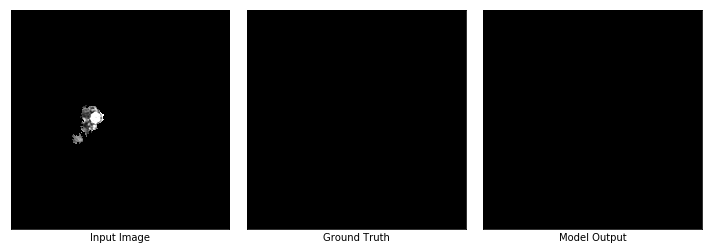

Steps: 111, Loss:0.8119956254959106
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.21262237429618835, max:0.18699190020561218



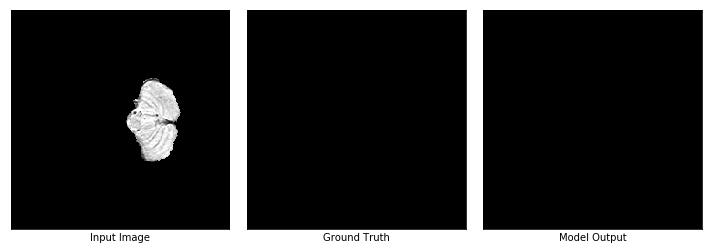

Steps: 112, Loss:0.883536696434021
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.08033327758312225, max:0.1020597293972969



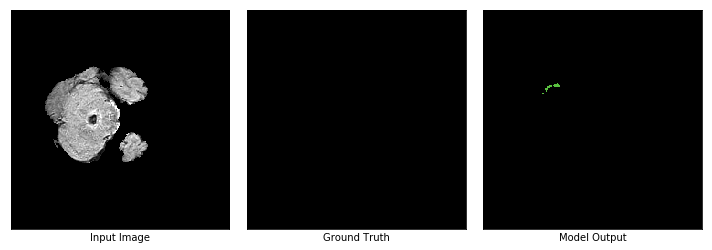

Steps: 113, Loss:0.9325525760650635
Accurary: 0.9992534518241882
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9992534722223518, 0.9992534722223518, 0.9992534722223518]
Gradient min:-0.21714355051517487, max:0.24424807727336884



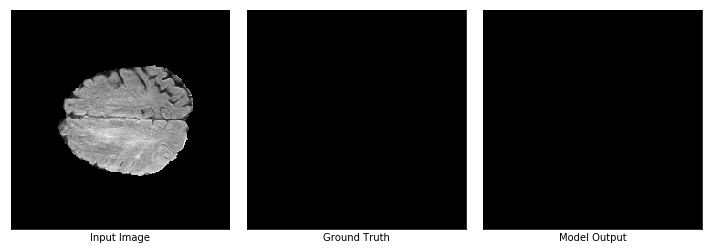

Steps: 114, Loss:0.8808092474937439
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05800529196858406, max:0.07758308947086334



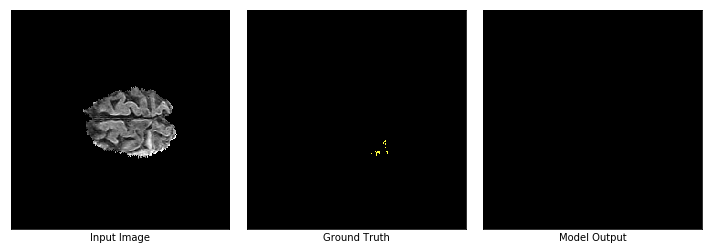

Steps: 115, Loss:0.8606987595558167
Accurary: 0.999340295791626
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 2.6315782548478277e-07]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.17143748700618744, max:0.15928871929645538



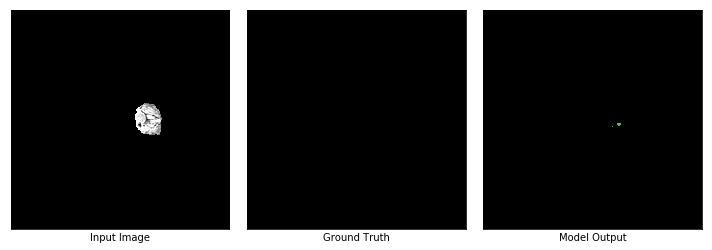

Steps: 116, Loss:0.8129134774208069
Accurary: 0.9997742772102356
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [0.9997743055555948, 0.9997743055555948, 0.9997743055555948]
Gradient min:-0.10456641763448715, max:0.09281106293201447



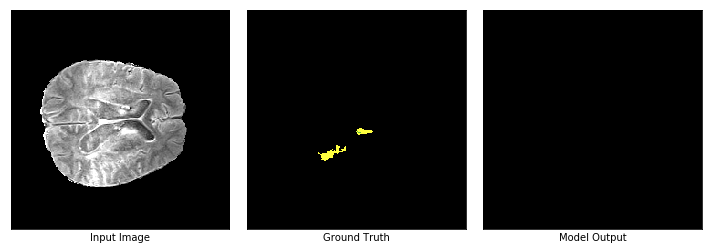

Steps: 117, Loss:0.7240806221961975
Accurary: 0.9953819513320923
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [2.4999937500156254e-06, 2.4999937500156254e-06, 3.759398354909837e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07856668531894684, max:0.066222183406353



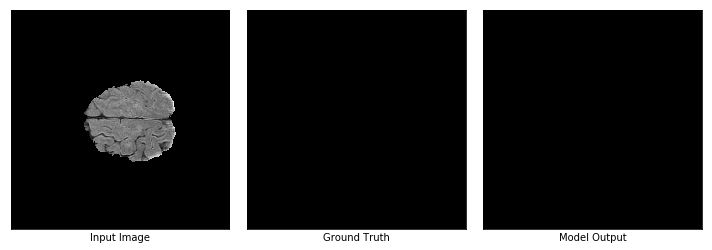

Steps: 118, Loss:0.8994247913360596
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.1346510350704193, max:0.16489097476005554



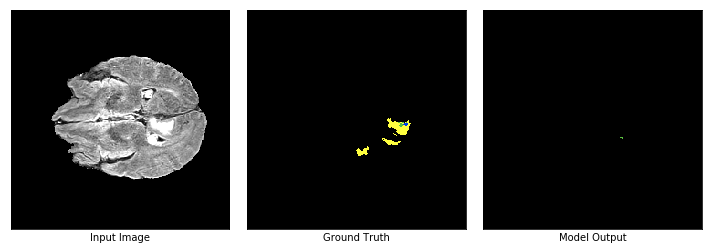

Steps: 119, Loss:0.8156366348266602
Accurary: 0.992517352104187
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [3.7037023319620994e-07, 6.249996093752442e-07, 2.341920319861351e-08]
Specificity: [0.9999305229882184, 0.9999305362600843, 0.9999300369055446]
Gradient min:-0.08284810930490494, max:0.09887643903493881



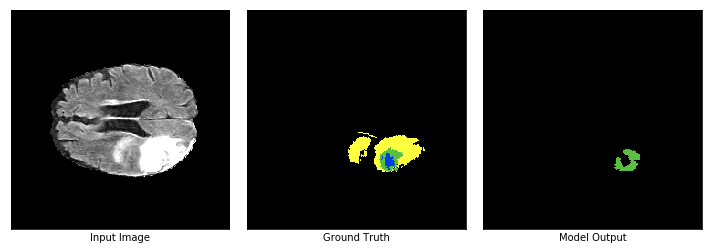

Steps: 120, Loss:0.8920849561691284
Accurary: 0.9690971970558167
Dice coefficient: [0.67934096, 0.73035437, 0.28995338]
Sensitivity: [0.6146789079202085, 0.8006756824096054, 0.17048853853196141]
Specificity: [0.9985130501716967, 0.9979757085023776, 0.999802136921286]
Gradient min:-0.10134606808423996, max:0.1178494319319725



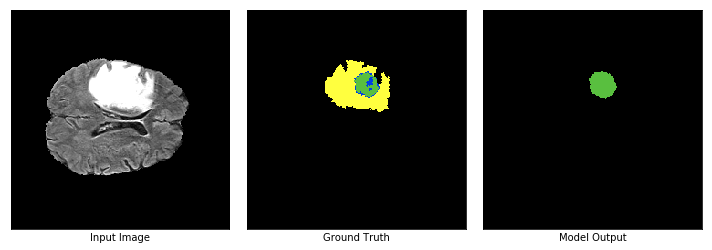

Steps: 121, Loss:0.8285789489746094
Accurary: 0.9577257037162781
Dice coefficient: [0.9190476, 0.79573715, 0.37210616]
Sensitivity: [0.99484536091331, 1.0, 0.23009776805133458]
Specificity: [0.9982637061983473, 0.9959756438976807, 0.9996528792751291]
Gradient min:-0.05083191767334938, max:0.03851395845413208



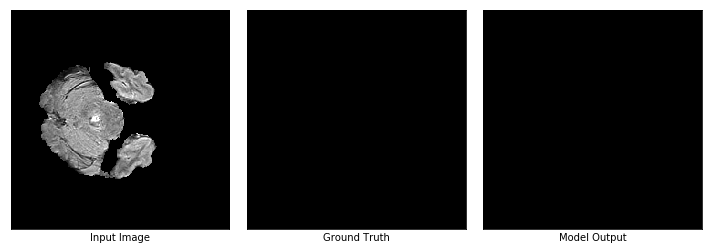

Steps: 122, Loss:0.8300045728683472
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.07789459824562073, max:0.06051439419388771



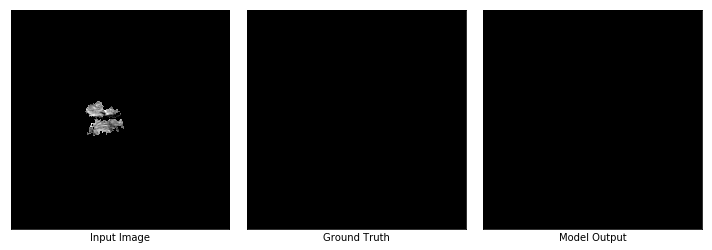

Steps: 123, Loss:0.8821372985839844
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.08222967386245728, max:0.06688950210809708



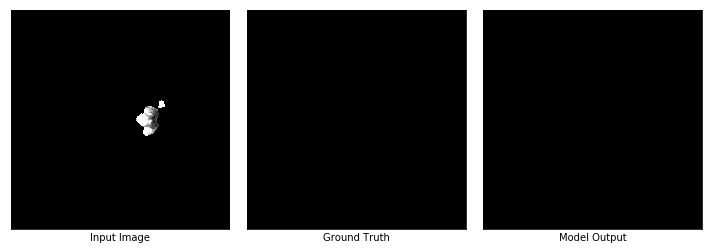

Steps: 124, Loss:0.8280764818191528
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06319698691368103, max:0.06366866827011108



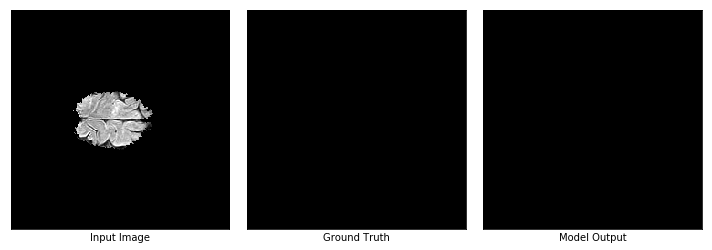

Steps: 125, Loss:1.0873712301254272
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.13867507874965668, max:0.13672935962677002



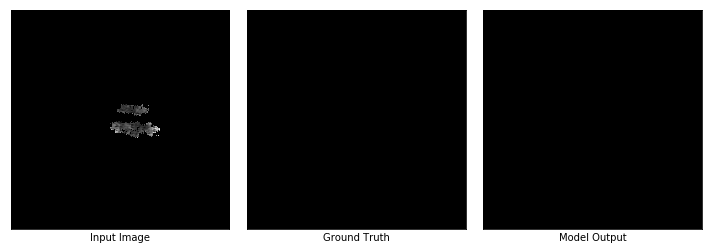

Steps: 126, Loss:0.7152715921401978
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03493386134505272, max:0.03891099616885185



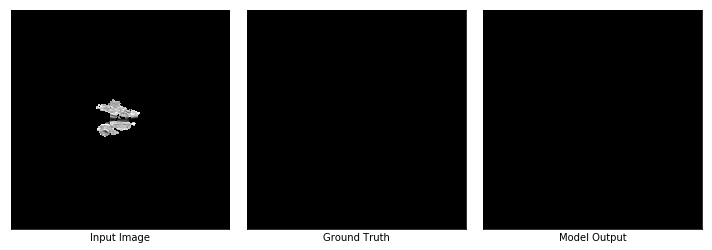

Steps: 127, Loss:0.8262325525283813
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.028648288920521736, max:0.025897052139043808



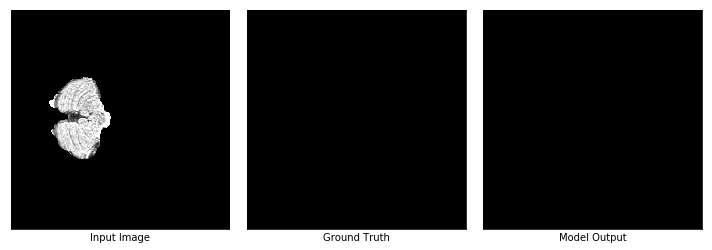

Steps: 128, Loss:0.8604335784912109
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.1301688849925995, max:0.1460806280374527



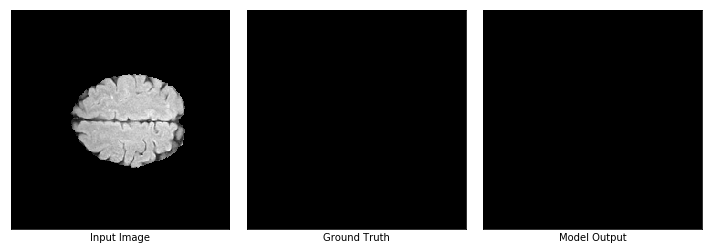

Steps: 129, Loss:0.8703333139419556
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.039999742060899734, max:0.04752519726753235



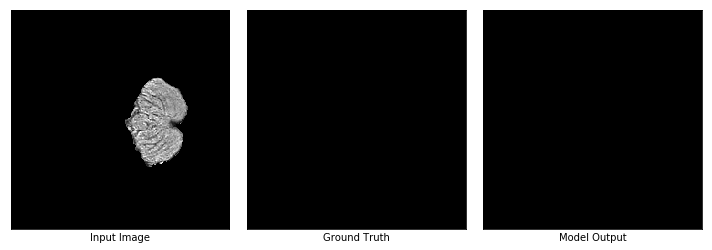

Steps: 130, Loss:0.7451434135437012
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.024945128709077835, max:0.027427254244685173



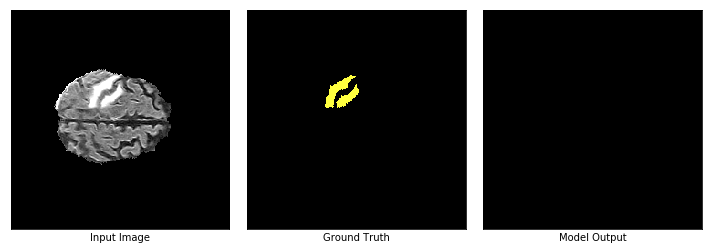

Steps: 131, Loss:0.8063889741897583
Accurary: 0.9891666769981384
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 1.6025640768819862e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.041339125484228134, max:0.058094322681427



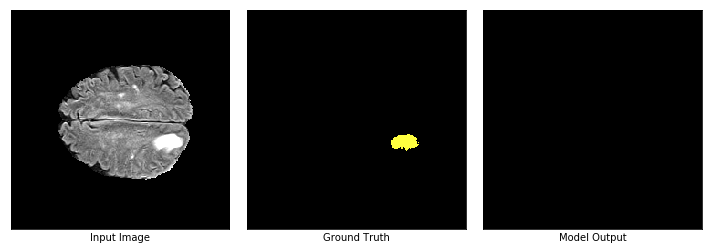

Steps: 132, Loss:0.9264687895774841
Accurary: 0.9934548735618591
Dice coefficient: [1.0, 1.0, 0.0]
Sensitivity: [1.0, 1.0, 2.6525198235405886e-08]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.023535175248980522, max:0.025137029588222504



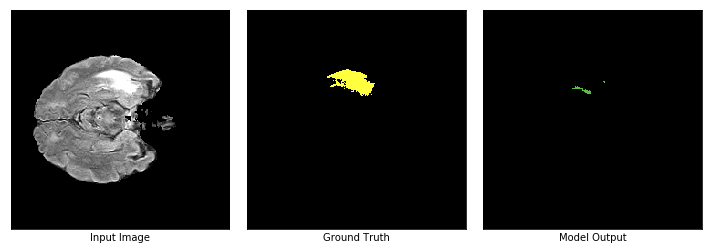

Steps: 133, Loss:0.7828120589256287
Accurary: 0.9854860901832581
Dice coefficient: [0.0, 0.0, 0.018957347]
Sensitivity: [1.0, 1.0, 0.010139429529284797]
Specificity: [0.9990451388890547, 0.9990451388890547, 0.9991726954288478]
Gradient min:-0.08606185019016266, max:0.07661387324333191



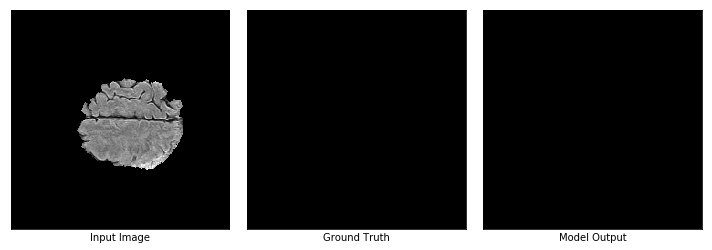

Steps: 134, Loss:0.8434377908706665
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.039873212575912476, max:0.03704783320426941



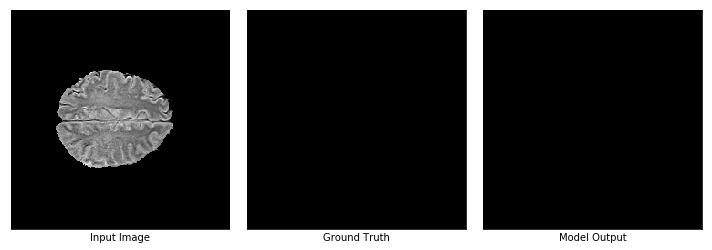

Steps: 135, Loss:0.7970320582389832
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15502159297466278, max:0.1334979236125946



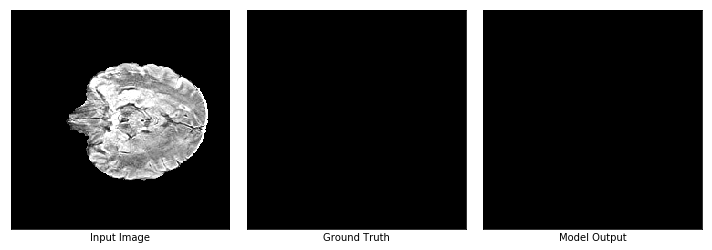

Steps: 136, Loss:0.8364052176475525
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.06736200302839279, max:0.0755189061164856



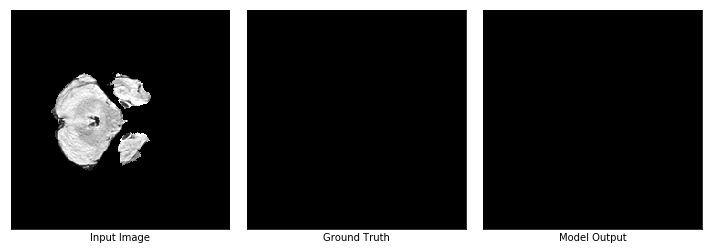

Steps: 137, Loss:0.9083952307701111
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15503618121147156, max:0.17747709155082703



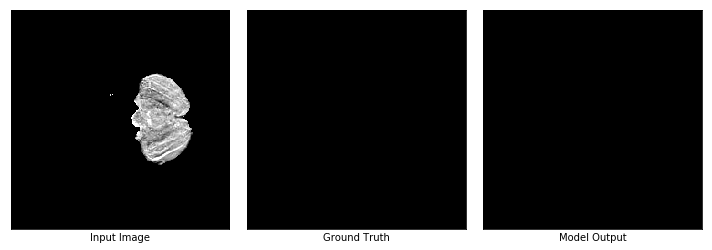

Steps: 138, Loss:0.74761962890625
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.012484947219491005, max:0.012202857993543148



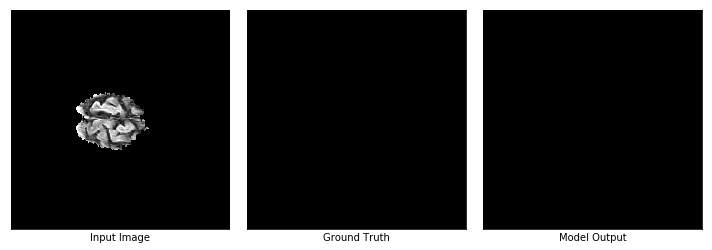

Steps: 139, Loss:0.7860349416732788
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03035900741815567, max:0.030183708295226097



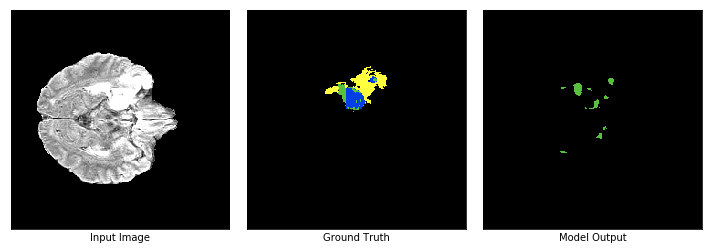

Steps: 140, Loss:0.7509204149246216
Accurary: 0.9756597280502319
Dice coefficient: [0.369863, 0.45378152, 0.22248381]
Sensitivity: [0.2713567961246768, 0.5482233731866308, 0.13309859765423523]
Specificity: [0.9979474764489681, 0.9970210616175076, 0.9983980064082595]
Gradient min:-0.22334231436252594, max:0.21849749982357025



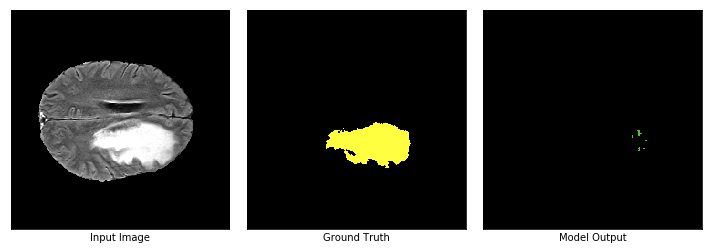

Steps: 141, Loss:0.869544506072998
Accurary: 0.9475347399711609
Dice coefficient: [0.0, 0.0, 0.018360656]
Sensitivity: [1.0, 1.0, 0.009268457433735658]
Specificity: [0.9994965277778652, 0.9994965277778652, 0.9999816779347401]
Gradient min:-0.12364570796489716, max:0.1017230823636055



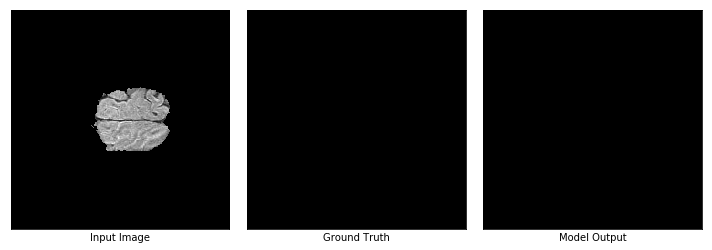

Steps: 142, Loss:0.8085182309150696
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.09095805138349533, max:0.12226962298154831



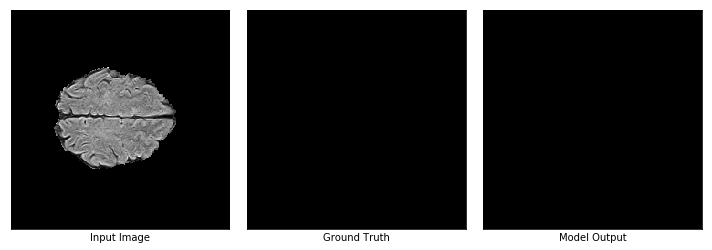

Steps: 143, Loss:0.7505979537963867
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.0607658326625824, max:0.07596556097269058



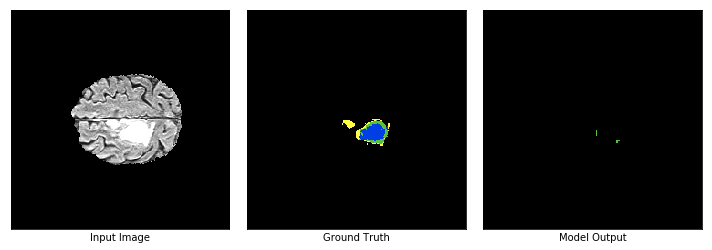

Steps: 144, Loss:0.8923839926719666
Accurary: 0.9868229031562805
Dice coefficient: [0.056013178, 0.115555555, 0.043092523]
Sensitivity: [0.02881357578282075, 0.06250004507211321, 0.02202073805672619]
Specificity: [1.0, 0.9999303038751167, 1.0]
Gradient min:-0.06122876703739166, max:0.08929222077131271



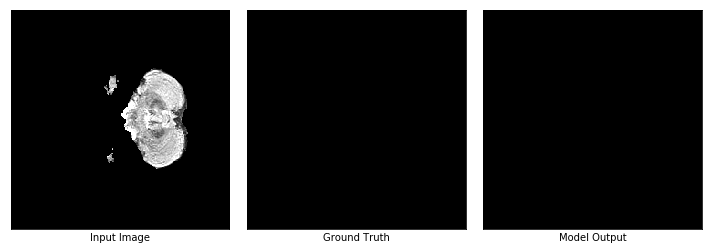

Steps: 145, Loss:0.801936149597168
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.3106023371219635, max:0.2706616222858429



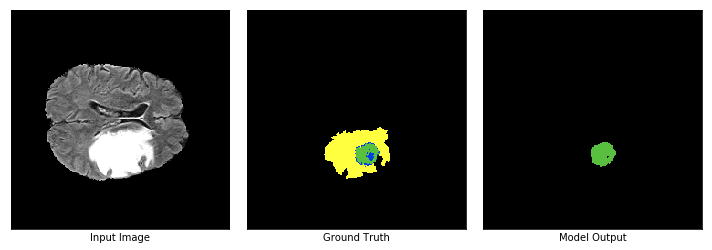

Steps: 146, Loss:0.8835488557815552
Accurary: 0.9584895968437195
Dice coefficient: [0.9517625, 0.84079087, 0.32784924]
Sensitivity: [0.9808795414745786, 0.9950738917469485, 0.19655667433085838]
Specificity: [0.9992641519352341, 0.9973598629231458, 0.9998722907392775]
Gradient min:-0.04819214344024658, max:0.06565087288618088



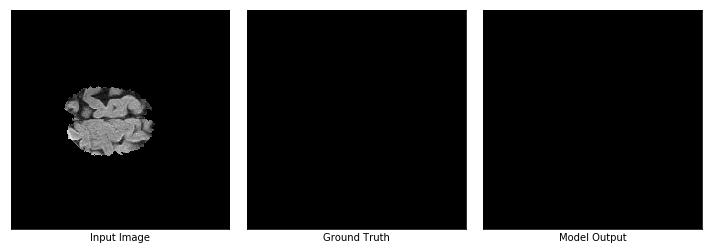

Steps: 147, Loss:0.767403244972229
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.05920938029885292, max:0.07324953377246857



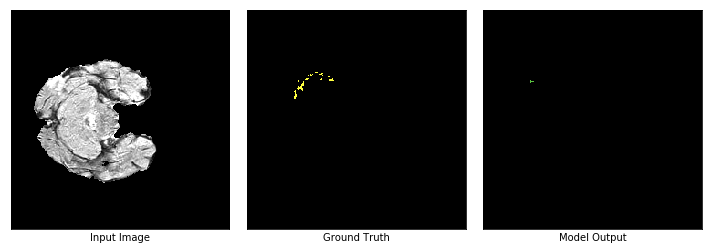

Steps: 148, Loss:0.8703169822692871
Accurary: 0.9982118010520935
Dice coefficient: [0.0, 0.0, 0.0]
Sensitivity: [1.0, 1.0, 1.0309277287703373e-07]
Specificity: [0.9998958333333514, 0.9998958333333514, 0.9998956576178816]
Gradient min:-0.19397932291030884, max:0.2278428077697754



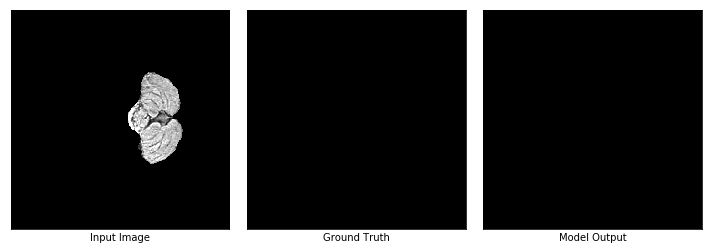

Steps: 149, Loss:0.7950406074523926
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.15726926922798157, max:0.19586654007434845



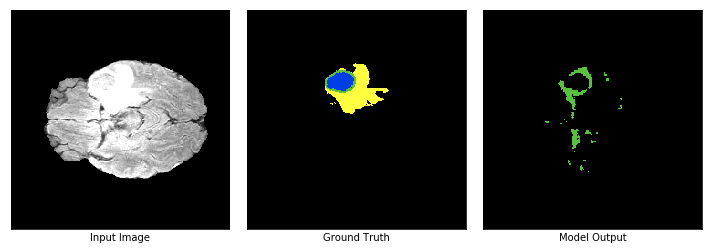

Steps: 150, Loss:0.9244420528411865
Accurary: 0.9593923687934875
Dice coefficient: [0.29543808, 0.33297297, 0.23629288]
Sensitivity: [0.30955994977906, 0.7586207015457782, 0.158669837726034]
Specificity: [0.990902864369979, 0.9901040124065537, 0.9930083791345151]
Gradient min:-0.2258761078119278, max:0.22029411792755127



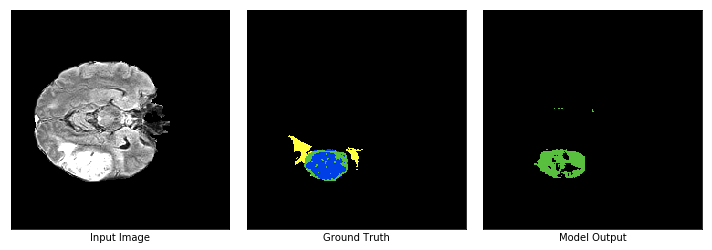

Steps: 151, Loss:0.8074804544448853
Accurary: 0.9736805558204651
Dice coefficient: [0.8106152, 0.50187266, 0.70841753]
Sensitivity: [0.755056181610066, 0.8933333357037037, 0.5786578681041922]
Specificity: [0.9974406824851256, 0.9868766404222438, 0.9982073070169217]
Gradient min:-0.2561112642288208, max:0.25300276279449463



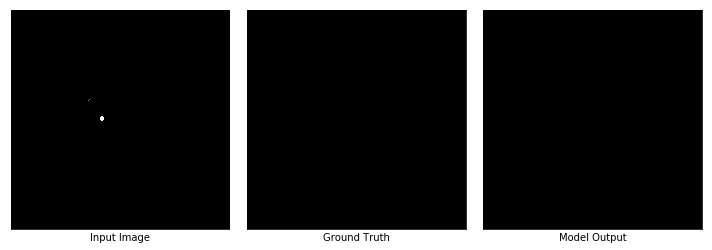

Steps: 152, Loss:0.7985062599182129
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.029246635735034943, max:0.0371578149497509



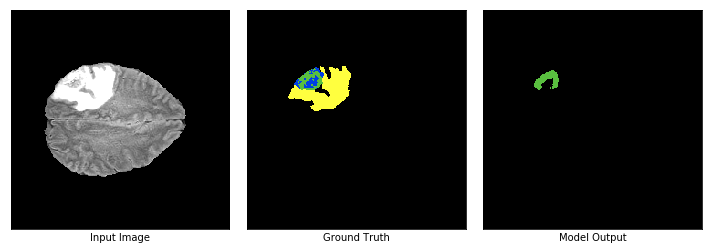

Steps: 153, Loss:0.8017097115516663
Accurary: 0.9657291769981384
Dice coefficient: [0.71631205, 0.7022654, 0.2472]
Sensitivity: [0.5749525697352453, 0.7257525175333607, 0.14167813323393794]
Specificity: [0.9997196572810751, 0.9982199263541265, 0.9998195564698353]
Gradient min:-0.11748725175857544, max:0.1350589394569397



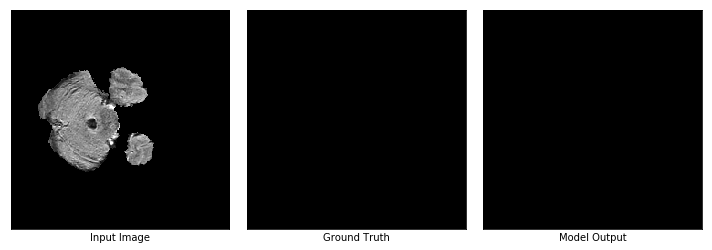

Steps: 154, Loss:0.6665031313896179
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.21349705755710602, max:0.2388681322336197



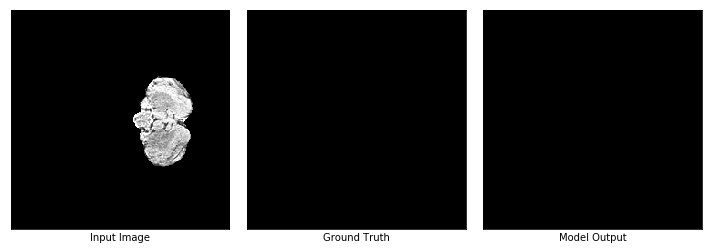

Steps: 155, Loss:0.9912029504776001
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.03426916524767876, max:0.025973618030548096



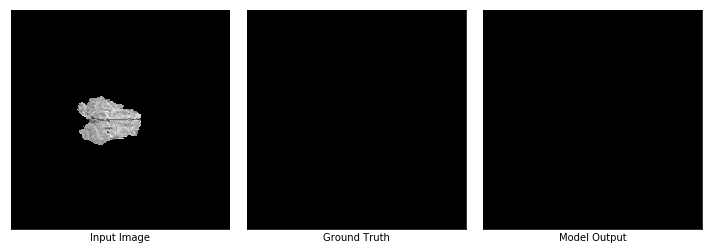

Steps: 156, Loss:0.7017207741737366
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.10875985026359558, max:0.11700648069381714



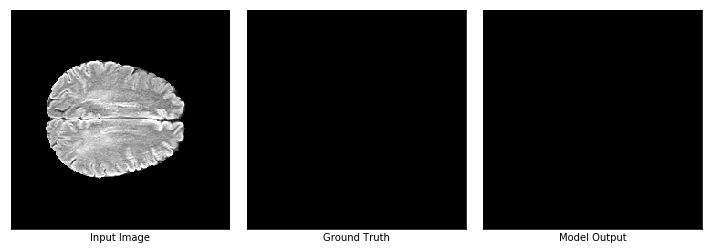

Steps: 157, Loss:0.8552917242050171
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.1393420249223709, max:0.14273233711719513



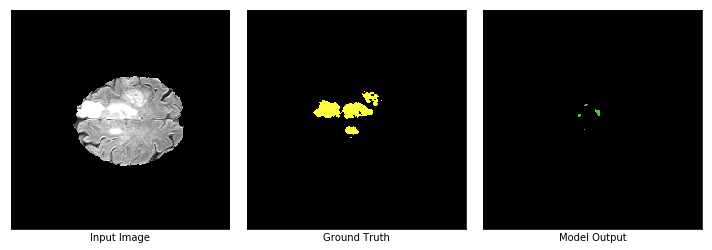

Steps: 158, Loss:0.7956733703613281
Accurary: 0.981006920337677
Dice coefficient: [0.0, 0.0, 0.056838367]
Sensitivity: [4.9999750001249995e-06, 1.0, 0.029520304155716756]
Specificity: [0.9992708080142938, 0.9992708333334599, 0.9998230589567869]
Gradient min:-0.23889178037643433, max:0.2306976467370987



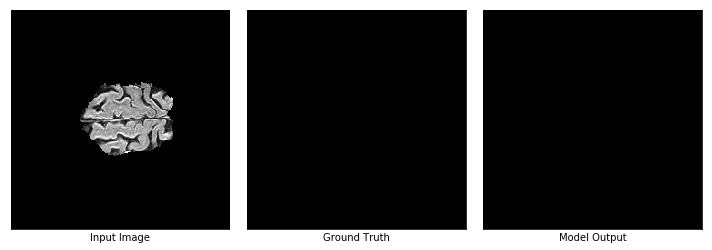

Steps: 159, Loss:0.7868283987045288
Accurary: 1.0
Dice coefficient: [1.0, 1.0, 1.0]
Sensitivity: [1.0, 1.0, 1.0]
Specificity: [1.0, 1.0, 1.0]
Gradient min:-0.12388647347688675, max:0.12365014106035233


In [ ]:
ds = os.listdir(tfrecords_read_dir)
kf = KFold(n_splits=len(ds),shuffle=True)
folds = 1
for train_id, val_id in kf.split(ds):
    print("Fold: {}".format(folds))
    epochs=1
    start = time.time()
    #list for training 
    loss_list = []
    acc_list = []
    loss_inner = []
    #for every fold we run(<=max_epochs)
    while epochs <= max_epochs:
        print("Epochs {:2d}".format(epochs))
        steps=1
        #training fold
        for idx in train_id:
            acc_inner = []
            dc_app = []
            sens_app = []
            spec_app = []
            train_tf = ds[idx]
            tf_dir = os.path.join(tfrecords_read_dir+train_tf)
            dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)     
            for imgs in dataset:
                #data augmentation
                imgs = data_aug(imgs)
                image = imgs[:,:,:,:4]
                #unprocessed label for plotting 
                label = imgs[:,:,:,-1]
                #for simplicity label 4 will be converted to 3 for sparse encoding
                label = tf.where(label==4,3,label)
                label = tf.keras.utils.to_categorical(label, num_classes=4)
                img_seg, loss, gradients = train_fn(image, label) #training function 
                #map from sparse to label
                img_seg = tf.math.argmax(img_seg,-1,output_type=tf.int32) 
                label = tf.math.argmax(label,-1,output_type=tf.int32)
                #accuracy of the output values for that batch
                acc = tf.reduce_mean(tf.cast(tf.equal(img_seg,label), tf.float32))
                #append accuracy for every steps
                acc_inner.append(acc)
                #accumulate dc score, sensitivity and specificity 
                dc_list, sens_list, spec_list =compute_metric(label,img_seg)
                dc_app.append(dc_list)
                sens_app.append(sens_list)
                spec_app.append(spec_list)
                #output
                if steps%1000==0:
                    input_img = [image[0,:,:,0], plot_labels_color(label[0]), plot_labels_color(img_seg[0])]
                    caption = ['Input Image', 'Ground Truth', 'Model Output']
                    plot_comparison(input_img, caption, n_col = 3, figsize=(10,10), captions_font = 10)
                    loss_list.append(loss)
                    acc_stp = tf.reduce_mean(tf.cast(tf.equal(img_seg[0],label[0]), tf.float32))
                    dc_list_stp, sens_list_stp, spec_list_stp =compute_metric(label[0],img_seg[0])
                    print("Steps: {}, Loss:{}".format(steps, loss))
                    print("Accurary: {}".format(acc_stp))
                    print("Dice coefficient: {}".format(dc_list_stp))
                    print("Sensitivity: {}".format(sens_list_stp))
                    print("Specificity: {}".format(spec_list_stp))
                    print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
                steps+=1
        acc_list.append(np.mean(acc_inner))
        mean_dc = np.mean(np.array(dc_app),0)
        mean_sens = np.mean(np.array(sens_app),0)
        mean_spec = np.mean(np.array(spec_app),0)
        print()
        print('-----------<Training summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list)))
        #'core','enhancing','complete'
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
        #validation
        acc_inner_val=[]
        dc_app_val = []
        sens_app_val = []
        spec_app_val = []
        val_tf = ds[val_id[0]]
        val_tf_dir = os.path.join(tfrecords_read_dir+val_tf)
        val_ds = utils.parse_tfrecord(val_tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for imgs in val_ds:
            image = imgs[:,:,:,:4]
            label = imgs[:,:,:,-1]
            label = tf.where(label==4,3,label)
            label = tf.keras.utils.to_categorical(label, num_classes=4)
            val_img_seg, val_loss = val_fn(image, label)
            val_img_seg = tf.math.argmax(val_img_seg,-1,output_type=tf.int32) 
            label = tf.math.argmax(label,-1,output_type=tf.int32)
            acc = tf.reduce_mean(tf.cast(tf.equal(val_img_seg,label), tf.float32))
            #append accuracy for every steps
            acc_inner_val.append(acc)
            #accumulate dc score, sensitivity and specificity 
            dc_list, sens_list, spec_list =compute_metric(label,val_img_seg)
            dc_app_val.append(dc_list)
            sens_app_val.append(sens_list)
            spec_app_val.append(spec_list)
            
        acc_list_val = np.mean(acc_inner)
        mean_dc = np.mean(np.array(dc_app_val),0)
        mean_sens = np.mean(np.array(sens_app_val),0)
        mean_spec = np.mean(np.array(spec_app_val),0)
        print()
        print('-----------<Validation summary for Epoch:{}>------------'.format(epochs))
        print("Mean Accuracy: {}".format(np.mean(acc_list_val)))
        #'core','enhancing','complete'
        print("Mean Dice coefficient: {}".format(mean_dc))
        print("Mean Sensitivity: {}".format(mean_sens))
        print("Mean Specificity: {}".format(mean_spec))
        print('------------------------------------------------')
        print()
        
        elapsed_time =(time.time()-start)/60 #unit in mins
        print("Compute time per epochs: {:.2f} mins".format(elapsed_time))
        epochs+=1 
    folds+=1
    print()

---

# Save Weights

In [ ]:
model.save_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))

---

# Validation 

In [ ]:
model.load_weights('/home/kevinteng/Desktop/model_weights/model_{}.h5'.format(ver))
def output_fn(image):
    model.trainable = False
    model_output = model(image)
    return model_output

In [ ]:
# ds = '/home/kevinteng/Desktop/ssd02/BraTS2020_preprocessed03/'
# save_path = '/home/kevinteng/Desktop/ssd02/submission/'
# actual_label = '/home/kevinteng/Desktop/ssd02/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii.gz'
# #all brain affine are the same just pick one 
# brain_affine = nib.load(actual_label).affine
# steps = 1
# acc_list = []
# for train_or_val in sorted(os.listdir(ds)):
#     save_dir = save_path + train_or_val+'_'+ver
#     if not os.path.exists(save_dir):
#         os.makedirs(save_dir)
#     merge01 = os.path.join(ds+train_or_val)
#     for patient in sorted(os.listdir(merge01)):
#         patient_id = patient.split('.')[0]
#         merge02 = os.path.join(merge01,patient)
#         imgs = np.load(merge02)
#         image = imgs[:,:,:,:4]
#         seg_output = 0 #flush RAM
#         seg_output = np.zeros((240,240,155))
#         for i in range(image.shape[0]):
#             inp = tf.expand_dims(image[i],0)
#             img_seg = output_fn(inp) #validation function 
#             #map from sparse to label
#             seg_output[:,:,i] = np.argmax(img_seg,-1) 
#         #convert label from 4 to 3 and np array and cast as int
#         seg_output= np.where(seg_output==3,4,seg_output).astype(np.uint8)
#         prediction_ni = nib.Nifti1Image(seg_output, brain_affine)
#         prediction_ni.to_filename(save_dir+'/{}.nii.gz'.format(patient_id))

---

# Model Summary

In [ ]:
model.summary()